In [125]:
#Only for use if you have all the input files in your own google drive and want to give access (will require changing file paths)
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import time
from scipy.optimize import curve_fit
import os

In [225]:
'''Define your inputs. Also set-up and read in'''
# get the start time
st = time.time()

'''SFR is no longer an input option and instead will be applied through a SFR light-ratio weighting method post-processing, which is still in progress'''
M_total = 1.0e6

IMF_exponents = [1.3, 2.3]
IMF_mass_limits = 0.1, 0.5, 120.

#Variable interpolation resolution factor, lower for speed up or higher for higher resolution isochrone interpolation
resolution_factor = 1

Z = 'Z0' #Z options are MWC, MW, LMC, SMC, IZw18 and Z0 (which correspond to Z=0.02, 0.014, 0.006, 0.002, 0.0004 and 0.0 respectively) although if the WMbasic OB models are used the spectra grid metallicities vary slightly)
SPEC = 'FW' #options are FW and WM which refer to the Fastwind and WMbasic OB spectral libraries
rot = False

plot_spec_with_time = True
spec_with_time_title = 'Evolution of Z0 SEDs with rotation'
plot_isochrones = True
plot_ion_flux = True
plot_spectral_types = False
plot_hires_spectra = False
plot_blackbody_scaling = False
plot_SN_rate = False
plot_new_hires = False
plot_wind = True
plot_uv_slope = False
plot_ew = False
plot_colours = False

save_output = False


In [226]:
if Z == 'MWC':
    !wget https://www.dropbox.com/scl/fi/s2pfp2bhln31im9t7rikz/Z020_pySB99_files.tar.gz?rlkey=x6rbry9j7gwxr83nqclvnt5fo&st=vspkqbns&dl=0
if Z == 'MW':
    !wget https://www.dropbox.com/scl/fi/cg3rtei88pbo0x453uss3/Z014_pySB99_files.tar.gz?rlkey=g14unl9czm1pabggh73vsiph5&st=xnw1u2g0&dl=0
if Z == 'LMC':
    !wget https://www.dropbox.com/scl/fi/3ncp8ao08igybvafpupmu/Z006_pySB99_files.tar.gz?rlkey=8lx36912iymf40na36wcj6d8m&st=1n2qjd0i&dl=0
if Z == 'SMC':
    !wget https://www.dropbox.com/scl/fi/2ii8essm93ms6chmrl79y/Z002_pySB99_files.tar.gz?rlkey=dv8yg8hchq19hz141mqwsg1g1&st=0maml717&dl=0
if Z == 'IZw18':
    !wget https://www.dropbox.com/scl/fi/van09gdlw0jhv4zwd61l8/Z0004_pySB99_files.tar.gz?rlkey=dqtxrchat6ci8tmici8dpco69&st=c23w79jl&dl=0
if Z == 'Z0':
    !wget https://www.dropbox.com/scl/fi/hbs19pc1nf8jj2i8ybjnq/Z00_pySB99_files.tar.gz?rlkey=mcmid0idndefvmbu8ltkwwgdq&st=aa841zn2&dl=0

--2025-02-06 20:32:36--  https://www.dropbox.com/scl/fi/hbs19pc1nf8jj2i8ybjnq/Z00_pySB99_files.tar.gz?rlkey=mcmid0idndefvmbu8ltkwwgdq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc216ae92d5242417a83d3851f36.dl.dropboxusercontent.com/cd/0/inline/Cjrhea5cHHksYfYEjw4pO8Z-cRbL1lQV7YMXxyEu6WfpdaV9E5pPYgfeWRcxwZSEehvWMIgHrgfPwnE-mqcef2n3Y8_Rc7fOaGvkG_7pBqRosb5lPfReEBzKQmp0ZfYBx2ojfNdeEF0BP-Nt5Wbm3inG/file# [following]
--2025-02-06 20:32:40--  https://uc216ae92d5242417a83d3851f36.dl.dropboxusercontent.com/cd/0/inline/Cjrhea5cHHksYfYEjw4pO8Z-cRbL1lQV7YMXxyEu6WfpdaV9E5pPYgfeWRcxwZSEehvWMIgHrgfPwnE-mqcef2n3Y8_Rc7fOaGvkG_7pBqRosb5lPfReEBzKQmp0ZfYBx2ojfNdeEF0BP-Nt5Wbm3inG/file
Resolving uc216ae92d5242417a83d3851f36.dl.dropboxusercontent.com (uc216ae92d5242417a83d3851f36.dl.dropboxusercontent.com)... 162.125.1

In [227]:
if Z == 'MWC':
    !tar -xzvf Z020_pySB99_files.tar.gz?rlkey=x6rbry9j7gwxr83nqclvnt5fo&st=vspkqbns&dl=0
if Z == 'MW':
    !tar -xzvf Z014_pySB99_files.tar.gz?rlkey=g14unl9czm1pabggh73vsiph5&st=xnw1u2g0&dl=0
if Z == 'LMC':
    !tar -xzvf Z006_pySB99_files.tar.gz?rlkey=8lx36912iymf40na36wcj6d8m&st=1n2qjd0i&dl=0
if Z == 'SMC':
    !tar -xzvf Z002_pySB99_files.tar.gz?rlkey=dv8yg8hchq19hz141mqwsg1g1&st=0maml717&dl=0
if Z == 'IZw18':
    !tar -xzvf Z0004_pySB99_files.tar.gz?rlkey=dqtxrchat6ci8tmici8dpco69&st=c23w79jl&dl=0
if Z == 'Z0':
    !tar -xzvf Z00_pySB99_files.tar.gz?rlkey=mcmid0idndefvmbu8ltkwwgdq&st=aa841zn2&dl=0

Z00_pySB99_files/
Z00_pySB99_files/WN_spec_params_powr_Z001.npy
Z00_pySB99_files/WN_spectra_powr_Z001.npy
Z00_pySB99_files/ifa_cont_m13_reform.npy
Z00_pySB99_files/._.DS_Store
tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
Z00_pySB99_files/.DS_Store
Z00_pySB99_files/WC_spec_params_cmfgen_Z001.npy
Z00_pySB99_files/spec_params_ifa_line_m13.npy
Z00_pySB99_files/WN_spectra_cmfgen_Z001.npy
Z00_pySB99_files/Z00v40_tracks.npy
Z00_pySB99_files/WC_spec_params_powr_Z001.npy
Z00_pySB99_files/lcb97_m13_reform.npy
Z00_pySB99_files/WC_spectra_cmfgen_Z001.npy
Z00_pySB99_files/._FW_SB_grid_Z0_VMS.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDLabel_6aeokwrt3fzqxpvx5oomejaizq'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring un

In [228]:
'''Load input files based on chosen metallicity and mass limits'''
if Z =='MWC':
    file_path = 'Z020_pySB99_files/'
    mass_grid = [300, 200., 150., 120., 85., 60., 40., 32., 25., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7, 1.5, 1.35, 1.25, 1.1, 1., 0.9, 0.8]
    if IMF_mass_limits[-1] > 300.:
        print('Tracks do not exist at Z=0.20 above 300Msol')
        exit()
    if rot == True:
        evo_tracks = np.load(file_path + 'Z020v40_VMS_tracks.npy')
        minimum_wr_mass=20.
    elif rot == False:
        evo_tracks = np.load(file_path + 'Z020v00_VMS_tracks.npy')
        minimum_wr_mass=20.
    if SPEC == 'WM':
        spectra_grid_file = file_path + 'galaxy/lejeune/WMbasic_OB_Z020_test.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z020_VMS.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassp00.npy')
    lowmass_flux = np.load(file_path + 'lcb97_p00_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_p00.npy')
    hires_flux = np.load(file_path + 'ifa_line_p00_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_p00_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z020.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z020.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z020.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z020.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z020.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z020.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z020.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z020.npy', allow_pickle=True)

if Z == 'MW':
    file_path = 'Z014_pySB99_files/'
    if rot == True:
        mass_grid = [300., 250., 180., 120., 85., 60., 40., 32., 25., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7, 1.5, 1.35, 1.25, 1.1, 1., 0.9, 0.8]
        if IMF_mass_limits[-1] > 300.:
            print('Tracks with rotation do not exist at Z=0.014 above 300Msol')
            exit()
        evo_tracks = np.load(file_path + 'Z014v40_VMS_tracks.npy')
        minimum_wr_mass=20.
    elif rot == False:
        mass_grid = [500., 300, 200., 150., 120., 85., 60., 50., 40., 32., 25., 23., 22., 20., 17., 15., 14., 12., 11.75, 11.5, 10., 9., 8., 7., 5., 4., 3., 2.5, 2., 1.7, 1.5, 1.35, 1.25, 1.1, 1., 0.9, 0.8]
        if IMF_mass_limits[-1] > 500.:
            print('Tracks do not exist at Z=0.014 above 500Msol')
            exit()
        evo_tracks = np.load(file_path + 'Z014v00_VMS_tracks.npy')
        minimum_wr_mass=25.
    if SPEC == 'WM':
        spectra_grid_file = file_path + 'WMbasic_OB_Z020_test.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z014.txt'
        if IMF_mass_limits[-1] > 120.0:
            spectra_grid_file = file_path + 'FW_SB_grid_Z014_VMS.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassp00.npy')
    lowmass_flux = np.load(file_path + 'lcb97_p00_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_p00.npy')
    hires_flux = np.load(file_path + 'ifa_line_p00_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_p00_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z020.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z020.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z020.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z020.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z020.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z020.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z020.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z020.npy', allow_pickle=True)

if Z == 'LMC':
    file_path = 'Z006_pySB99_files/'
    mass_grid = [300, 250., 180., 120., 85., 60., 40., 32., 25., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7, 1.5, 1.35, 1.25, 1.1, 1., 0.9, 0.8]
    if IMF_mass_limits[-1] > 300.:
        print('Tracks do not exist at Z=0.006 above 300Msol')
        exit()
    if rot == True:
        evo_tracks = np.load(file_path + 'Z006v40_VMS_tracks.npy')
        minimum_wr_mass=25.
    elif rot == False:
        evo_tracks = np.load(file_path + 'Z006v00_VMS_tracks.npy')
        minimum_wr_mass=25.
    if SPEC == 'WM':
        spectra_grid_file = file_path + 'galaxy/lejeune/WMbasic_OB_Z008_tst.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z006.txt'
        if IMF_mass_limits[-1] > 120.0:
            spectra_grid_file = file_path + 'FW_SB_grid_Z006_VMS.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassm04.npy')
    lowmass_flux = np.load(file_path + 'lcb97_m04_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_m04.npy')
    hires_flux = np.load(file_path + 'ifa_line_m04_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_m04_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z008.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z008.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z008.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z008.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z008.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z008.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z008.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z008.npy', allow_pickle=True)

if Z == 'SMC':
    file_path = 'Z002_pySB99_files/'
    mass_grid = [120., 85., 60., 40., 32., 25., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7, 1.5, 1.35, 1.25, 1.1, 1., 0.9, 0.8]
    if IMF_mass_limits[-1] > 120.:
        print('Tracks do not exist at Z=0.002 above 120Msol')
        exit()
    if rot == True:
        evo_tracks = np.load(file_path + 'Z002v40_tracks.npy')
        minimum_wr_mass=84.
    elif rot == False:
        evo_tracks = np.load(file_path + 'Z002v00_tracks.npy')
        minimum_wr_mass=84.
    if SPEC == 'WM':
        spectra_grid_file = file_path + 'galaxy/lejeune/WMbasic_OB_Z004_tst.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z002.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassm07.npy')
    lowmass_flux = np.load(file_path + 'lcb97_m07_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_m07.npy')
    hires_flux = np.load(file_path + 'ifa_line_m07_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_m07_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z004.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z004.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z004.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z004.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z004.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z004.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z004.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z004.npy', allow_pickle=True)

if Z == 'IZw18':
    file_path = 'Z0004_pySB99_files/'
    mass_grid = [120., 85., 60., 40., 32., 25., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7]
    if IMF_mass_limits[-1] > 120.:
        print('Tracks do not exist at 0.0004 above 120Msol')
        exit()
    if rot == True:
        evo_tracks = np.load(file_path + 'Z0004v40_tracks.npy')
        minimum_wr_mass=84.
    elif rot == False:
        evo_tracks = np.load(file_path + 'Z0004v00_tracks.npy')
        minimum_wr_mass=84.
    if SPEC == 'WM':
        spectra_grid_file = 'galaxy/lejeune/WMbasic_OB_Z001_tst.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z0004.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassm13.npy')
    lowmass_flux = np.load(file_path + 'lcb97_m13_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_m13.npy')
    hires_flux = np.load(file_path + 'ifa_line_m13_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_m13_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z001.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z001.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z001.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z001.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z001.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z001.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z001.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z001.npy', allow_pickle=True)

if Z == 'Z0':
    file_path = 'Z00_pySB99_files/'
    if rot == True:
        mass_grid = [120., 85., 60., 40., 30., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7]
        if IMF_mass_limits[-1] > 120.:
            print('Tracks with rotation do not exist at Z=0.0 above 120Msol')
            exit()
        evo_tracks = np.load(file_path + 'Z00v40_tracks.npy')
        minimum_wr_mass=84.
    elif rot == False:
        mass_grid = [300., 250., 120., 85., 60., 40., 30., 20., 15., 12., 9., 7., 5., 4., 3., 2.5, 2., 1.7]
        if IMF_mass_limits[-1] > 300.:
            print('Tracks do not exist at Z=0.0 above 300Msol')
            exit()
        evo_tracks = np.load(file_path + 'Z00v00_tracks.npy')
        minimum_wr_mass=84.
    if SPEC == 'WM':
        spectra_grid_file = 'galaxy/lejeune/WMbasic_OB_Z001_tst.dat'
    if SPEC == 'FW':
        spectra_grid_file = file_path + 'FW_SB_grid_Z0.txt'
        if IMF_mass_limits[-1] > 120.0:
            spectra_grid_file = file_path + 'FW_SB_grid_Z0_VMS.txt'
    lowmass_params = np.load(file_path + 'spec_params_lowmassm13.npy')
    lowmass_flux = np.load(file_path + 'lcb97_m13_reform.npy')# * 12
    hires_params = np.load(file_path + 'spec_params_ifa_line_m13.npy')
    hires_flux = np.load(file_path + 'ifa_line_m13_reform.npy')
    hires_cont_flux = np.load(file_path + 'ifa_cont_m13_reform.npy')
    WN_spec_params = np.load(file_path + 'WN_spec_params_cmfgen_Z001.npy')
    WN_spectra = np.load(file_path + 'WN_spectra_cmfgen_Z001.npy', allow_pickle=True)
    WC_spec_params = np.load(file_path + 'WC_spec_params_cmfgen_Z001.npy')
    WC_spectra = np.load(file_path + 'WC_spectra_cmfgen_Z001.npy', allow_pickle=True)
    WN_spec_params_powr = np.load(file_path + 'WN_spec_params_powr_Z001.npy')
    WN_spectra_powr = np.load(file_path + 'WN_spectra_powr_Z001.npy', allow_pickle=True)
    WC_spec_params_powr = np.load(file_path + 'WC_spec_params_powr_Z001.npy')
    WC_spectra_powr = np.load(file_path + 'WC_spectra_powr_Z001.npy', allow_pickle=True)

#Choose between PoWR and WMbasic for OB high resolution UV spectral grid
POWR = False #PoWR OB grid capability is not yet implemented so this should be False to use the WMbasic OB grid
if POWR == True:
    hires_wave_grid = np.linspace(920, 3100, 10000)
    empty_hires_flux = np.full_like(hires_wave_grid, 0.0)
if POWR == False:
    hires_wave_grid = np.load(file_path + 'hires_wave_grid.npy')
    empty_hires_flux = np.full_like(hires_wave_grid, 0.0)

times_spectra = np.arange(0.01e6, 50e6, 1e6)
times_steps = np.arange(0.00e6, 50e6, 0.1e6)
times_steps_SB99 = np.arange(0.01e6, 50e6, 0.1e6)

In [229]:
def calc_Nostars(IMF_masses, IMF_exponents, IMF_mass_limits):
    '''
    Compute normalisation constants for IMF for a 1-power or 2-power law IMF. Then computes number of stars per mass bin.
    A is the normalisation constants for each part of the IMF.
    Only supports 1 or 2 IMF intervals for now, has to be updated to have more than 2
    '''
    #Determine number of IMF intervals based on input IMF intervals
    if len(IMF_exponents) == 1:
        N_IMF_intervals = 1
    elif len(IMF_exponents) > 1:
        N_IMF_intervals = 2

    #compute variables for IMF normalisation constants
    if N_IMF_intervals > 1:
        N_IMF_intervals = len(IMF_exponents)
        A_ic = np.zeros_like(IMF_exponents)
        A_ic[0] = 1.

        for exponent_index in range(len(IMF_exponents)):
            exponent_index=exponent_index+1 #skip first IMF_exponent
            if exponent_index == len(IMF_exponents):
                break #this is just a quick stop when we reach the end of the IMF exponents (if i=2 when we have len=2 for 2 exponents then it stops instead of looking for ind=2 )
            A_i = A_ic[exponent_index-1] * (IMF_mass_limits[exponent_index]**(IMF_exponents[exponent_index] - IMF_exponents[exponent_index-1]))
            #print(Aici)
            A_ic[exponent_index] = A_i #set new value
        k_ic=[]
        for exponent_index in range(len(IMF_exponents)):
            if IMF_exponents[exponent_index] == 2.0:
                k_i = np.log(IMF_mass_limits[exponent_index+1])-np.log(IMF_mass_limits[exponent_index])
            else:
                k_i = ( IMF_mass_limits[exponent_index+1]**(2.0 - IMF_exponents[exponent_index]) - IMF_mass_limits[exponent_index]**(2.0 - IMF_exponents[exponent_index]) ) / (2 - IMF_exponents[exponent_index])
            k_ic.append(k_i)

        Ak_ic = A_ic * k_ic
        Ak = sum(Ak_ic)

    else: #If N_IMF_intervals = 1
        A_ic = 1
        k_ic = ( IMF_mass_limits[1]**(2.0 - IMF_exponents[0]) - IMF_mass_limits[0]**(2.0 - IMF_exponents[0]) ) / (2 - IMF_exponents[0])
        Ak = A_ic * k_ic

    S = M_total / Ak
    A = A_ic * S #Here are the normalisation constants

    xmhigh = np.full_like(IMF_masses, 0)
    xmlow = np.full_like(IMF_masses, 0)

    for mass_index in range(len(IMF_masses)): #set width of bin for each individual IMF mass through upper and lower limits
        if IMF_masses[mass_index] == min(IMF_masses):
            xmhigh[mass_index] = 0.5*(IMF_masses[mass_index]+IMF_masses[mass_index+1])
            xmlow[mass_index]  = IMF_masses[mass_index]
        elif IMF_masses[mass_index] == max(IMF_masses):
            xmhigh[mass_index] = IMF_masses[mass_index]
            xmlow[mass_index]  = 0.5*(IMF_masses[mass_index-1]+IMF_masses[mass_index])
        else:
            xmhigh[mass_index] = 0.5*(IMF_masses[mass_index]+IMF_masses[mass_index+1])
            xmlow[mass_index] = 0.5*(IMF_masses[mass_index]+IMF_masses[mass_index-1])

    dens = []
    #compute number of stars per mass bin
    if N_IMF_intervals == 2:
        for mass_index in range(len(IMF_masses)):
            dens_i = A[1] * ( xmhigh[mass_index]**(1-IMF_exponents[1]) - xmlow[mass_index]**(1-IMF_exponents[1]) ) / (1 - IMF_exponents[1])
            dens.append(dens_i)
    else:
        for mass_index in range(len(IMF_masses)):
            dens_i = A * ( xmhigh[mass_index]**(1-IMF_exponents[0]) - xmlow[mass_index]**(1-IMF_exponents[0]) )  / (1 - IMF_exponents[0])
            dens.append(dens_i)

    N_stars = np.array(dens)
    total_mass = N_stars * IMF_masses
    #print('Total No stars = ','{:0.4E}'.format(sum(N_stars).item()),'Total mass = ','{:0.4E}'.format(np.sum(total_mass)))
    return(N_stars, IMF_masses, dens, xmhigh, xmlow)

In [230]:
mass_grid = np.array(mass_grid)
mass_grid_str = mass_grid.astype('str')

ids = evo_tracks[:,0]
ages = evo_tracks[:,1]
masses = evo_tracks[:,2]
luminosities = evo_tracks[:,3]
temperatures = evo_tracks[:,4]
H_abundances = evo_tracks[:,5]
He_abundances = evo_tracks[:,6]
abundance_12C = evo_tracks[:,7]
abundance_14N = evo_tracks[:,8]
abundance_16O = evo_tracks[:,9]
core_temperatures = evo_tracks[:,10]
mass_loss_rates = evo_tracks[:,11]
#split tracks into individual sub-arrays
split_factor = len(mass_grid)
track_ids = np.array_split(ids, split_factor)
track_masses = np.array_split(masses, split_factor)
track_ages = np.array_split(ages, split_factor)
track_lums = np.array_split(luminosities,split_factor)
track_temps = np.array_split(temperatures,split_factor)
track_H_abundances = np.array_split(H_abundances,split_factor)
track_He_abundances = np.array_split(He_abundances,split_factor)
track_12C_abundances = np.array_split(abundance_12C,split_factor)
track_14N_abundances = np.array_split(abundance_14N,split_factor)
track_16O_abundances = np.array_split(abundance_16O,split_factor)
track_core_temps = np.array_split(core_temperatures,split_factor)
track_mass_loss_rates = np.array_split(mass_loss_rates,split_factor)
#set initial age for all tracks to 0.0
for i in track_ages:
    i[0] = 1.0e-3

for i in range(len(track_temps)):
    track_ages[i] = np.append(track_ages[i], np.array([track_ages[i][-1] + 100., (track_ages[i][-1] + 100.) * 10**6]))
    track_lums[i] = np.append(track_lums[i], np.array([-20., -20.]))
    track_temps[i] = np.append(track_temps[i], np.array([track_temps[i][-1], track_temps[i][-1]]))
    track_masses[i] = np.append(track_masses[i], np.array([track_masses[i][-1], track_masses[i][-1]]))
    #track_masses[i] = np.append(track_masses[i], np.array([0, track_masses[i][-1]]))
    track_H_abundances[i] = np.append(track_H_abundances[i], np.array([track_H_abundances[i][-1], track_H_abundances[i][-1]]))
    track_He_abundances[i] = np.append(track_He_abundances[i], np.array([track_He_abundances[i][-1], track_He_abundances[i][-1]]))
    track_12C_abundances[i] = np.append(track_12C_abundances[i], np.array([track_12C_abundances[i][-1], track_12C_abundances[i][-1]]))
    track_14N_abundances[i] = np.append(track_14N_abundances[i], np.array([track_14N_abundances[i][-1], track_14N_abundances[i][-1]]))
    track_16O_abundances[i] = np.append(track_16O_abundances[i], np.array([track_16O_abundances[i][-1], track_16O_abundances[i][-1]]))
    track_core_temps[i] = np.append(track_core_temps[i], np.array([track_core_temps[i][-1], track_core_temps[i][-1]]))
    track_mass_loss_rates[i] = np.append(track_mass_loss_rates[i], np.array([track_mass_loss_rates[i][-1], track_mass_loss_rates[i][-1]]))

for i in range(len(track_mass_loss_rates)):
    for j in range(len(track_mass_loss_rates[0])):
        if track_mass_loss_rates[i][j] > -1:
            track_mass_loss_rates[i][j] = -1000

#transpose or flip arrays to put in increasing mass order
track_masses_increasing = np.transpose(track_masses)
#mass increasing index
track_ages_massincind = np.transpose(track_ages)
track_lums_mass_incind = np.transpose(track_lums)
track_temps_mass_incind = np.transpose(track_temps)
track_H_abundances_mass_incind = np.transpose(track_H_abundances)
track_He_abundances_mass_incind = np.transpose(track_He_abundances)
track_12C_abundances_mass_incind = np.transpose(track_12C_abundances)
track_14N_abundances_mass_incind = np.transpose(track_14N_abundances)
track_16O_abundances_mass_incind = np.transpose(track_16O_abundances)
track_core_temps_mass_incind = np.transpose(track_core_temps)
track_mass_loss_rates_mass_incind = np.transpose(track_mass_loss_rates)

In [231]:
def read_spectra_grid(spec_file):
    df = pd.read_csv(spec_file)

    ind_spec = [i for i in range(len(df)) if df['start'][i] == ' CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC']

    spec_params = []
    spectra = []
    for i in range(len(ind_spec)-1):
        spec_param = df['start'][ind_spec[i]+1]
        spec_params.append(spec_param)

    for i in range(len(ind_spec)-1):
        spec_param = df['start'][ind_spec[i]+2 : ind_spec[i+1]]
        spectra.append(spec_param)
    return(spec_params, spectra)

spec_params, spectra = read_spectra_grid(spectra_grid_file)

In [232]:
def reformat_spec(spectrum):
    wave_reform = []
    flux_reform = []
    for i in spectrum:
        spec_wavep, spec_fluxp = i.split()
        wavep_app = float(spec_wavep)
        wave_reform.append(wavep_app)
        fluxp_app = float(spec_fluxp) * 4.0 * 3.14142
        flux_reform.append(fluxp_app)
    flux_reform = np.array(flux_reform)# + 12.566# * 4e10
    spec_reform = np.column_stack((wave_reform, flux_reform))
    return (spec_reform)

def reformat_spec_WR(spectrum):
    wave_reform = []
    flux_reform = []
    for i in spectrum:
        spec_wavep, spec_fluxp = i.split()
        wavep_app = float(spec_wavep)
        wave_reform.append(wavep_app)
        fluxp_app = float(spec_fluxp)# * 12.566
        flux_reform.append(fluxp_app)
    flux_reform = np.array(flux_reform)# + 12.566# * 4e10
    spec_reform = np.column_stack((wave_reform, flux_reform))
    return (spec_reform)

def reform_spec_grid(spectra, spec_params):
    reformed_spec_grid = []
    for i in range(len(spectra)):
        reformatted_spec = reformat_spec(spectra[i])
        reformed_spec_grid.append(reformatted_spec)

    spec_params_id = []
    spec_params_teff = []
    spec_params_logl = []
    spec_params_logg = []
    for i in spec_params:
        spec_id, spec_teff, spec_logl, spec_logg = i.split()
        spec_id = float(spec_id)
        spec_params_id.append(spec_id)
        spec_teff = float(spec_teff)
        spec_params_teff.append(spec_teff)
        spec_logl = float(spec_logl)
        spec_params_logl.append(spec_logl)
        spec_logg = float(spec_logg)
        spec_params_logg.append(spec_logg)
    spec_params_teff = 10**np.array(spec_params_teff)
    spec_params_reform = np.column_stack((spec_params_id, spec_params_teff, spec_params_logl, spec_params_logg))
    return(reformed_spec_grid, spec_params_reform, spec_params_teff, spec_params_logl, spec_params_logg)

def reform_spec_grid_WR(spectra, spec_params):
    reformed_spec_grid = []
    for i in range(len(spectra)):
        reformatted_spec = reformat_spec_WR(spectra[i])
        reformed_spec_grid.append(reformatted_spec)

    spec_params_id = []
    spec_params_teff = []
    for i in spec_params:
        spec_id, spec_teff = i.split()
        spec_id = float(spec_id)
        spec_params_id.append(spec_id)
        spec_teff = float(spec_teff)
        spec_params_teff.append(spec_teff)
    spec_params_teff = np.array(spec_params_teff)
    spec_params_reform = np.column_stack((spec_params_id, spec_params_teff))
    return(reformed_spec_grid, spec_params_reform, spec_params_teff)

def reform_spec_grid_powr(spectra, spec_params):
    reformed_spec_grid = []
    for i in range(len(spectra)):
        reformatted_spec = reformat_spec_WR(spectra[i])
        reformed_spec_grid.append(reformatted_spec)

    spec_params_id = []
    spec_params_teff = []
    spec_params_radius = []
    spec_params_length = []
    for i in spec_params:
        spec_id, spec_teff, spec_radius, spec_length = i.split()
        spec_id = float(spec_id)
        spec_params_id.append(spec_id)
        spec_teff = float(spec_teff)
        spec_params_teff.append(spec_teff)
        spec_radius = float(spec_radius)
        spec_params_radius.append(spec_radius)
        spec_length = float(spec_length)
        spec_params_length.append(spec_length)
    spec_params_teff = np.array(spec_params_teff)
    spec_params_reform = np.column_stack((spec_params_id, spec_params_teff, spec_params_radius, spec_params_length))
    return(reformed_spec_grid, spec_params_reform, spec_params_teff, spec_params_radius, spec_params_length)

reformed_spec_grid, spec_params_reform, spec_params_teff, spec_params_logl, spec_params_logg = reform_spec_grid(spectra, spec_params)
spectrum = reformed_spec_grid[0]
wave_grid = spectrum[:,0]
empty_flux = np.full_like(wave_grid, 0.0)

WN_reformed_spec_grid, WN_spec_params_reform, WN_spec_params_teff= reform_spec_grid_WR(WN_spectra, WN_spec_params)
WC_reformed_spec_grid, WC_spec_params_reform, WC_spec_params_teff= reform_spec_grid_WR(WC_spectra, WC_spec_params)

WC_reformed_spec_grid_powr, WC_spec_params_reform_powr, WC_spec_params_teff_powr, WC_spec_params_radius_powr, WC_spec_params_length_powr= reform_spec_grid_powr(WC_spectra_powr, WC_spec_params_powr)
WN_reformed_spec_grid_powr, WN_spec_params_reform_powr, WN_spec_params_teff_powr, WN_spec_params_radius_powr, WN_spec_params_length_powr= reform_spec_grid_powr(WN_spectra_powr, WN_spec_params_powr)


In [233]:
def integrate_spec_grid(reformed_spec_grid):
    integrated_spectra = []
    for i in range(len(reformed_spec_grid)):
        integrated_spectrum = np.trapz(reformed_spec_grid[i][:,1], reformed_spec_grid[i][:,0])
        integrated_spectra.append(integrated_spectrum)
    return(integrated_spectra)

def integrate_spec_grid_powr(wave_grid, reformed_spec_grid):
    integrated_spectra = []
    for i in range(len(reformed_spec_grid)):
        integrated_spectrum = np.trapz(wave_grid, reformed_spec_grid[i,:])
        integrated_spectra.append(integrated_spectrum)
    return(integrated_spectra)

integrated_spectra = integrate_spec_grid(reformed_spec_grid)

WN_integrated_spectra = integrate_spec_grid(WN_reformed_spec_grid)
WC_integrated_spectra = integrate_spec_grid(WC_reformed_spec_grid)

WN_integrated_spectra_powr = integrate_spec_grid(WN_reformed_spec_grid_powr)
WC_integrated_spectra_powr = integrate_spec_grid(WC_reformed_spec_grid_powr)

In [234]:
def interpolate_param(tracks_parameter, track_masses):
    '''
    Performs an interpolation between two adjacent tracks in evolutionary diagrams. This is done to create synthetic
    tracks for each mass in the grid to fill in the gaps offered by the tracks.
    Returns an array of 23 sub-arrays (the interpolation between each of the 24 tracks). These contain 400 arrays (for each point in the tracks)
    which have a length indicating how many synthetic tracks are produced between the two tracks, depends on mass range
    covered by the two tracks, e.g. 36 tracks are needed between 120 and 85 Msol but only one is needed between the lowest mass tracks.

    Should really rework the arrays so the output is just an array of 120 tracks of length 400.
    '''
    grid_masses_adjinterp_total = []
    grid_params_adjinterp_total = []
    for i in range(len(track_masses)-1):
        track_mass_upper = np.flip(track_masses[i])
        track_param_upper = np.flip(tracks_parameter[i])
        track_mass_lower = np.flip(track_masses[i+1])
        track_param_lower = np.flip(tracks_parameter[i+1])

        initial_mass_upper = track_mass_upper[-1]
        initial_mass_lower = track_mass_lower[-1]

        inter_track_sampling = ( initial_mass_upper - initial_mass_lower +1 ) * (resolution_factor / 1)

        track_masses_adjinterp = np.column_stack((track_mass_lower, track_mass_upper))
        track_param_adjinterp = np.column_stack((track_param_lower, track_param_upper))

        grid_masses_adjinterp = []

        for j in range(len(track_mass_upper)):
            grid_mass_adjinterp = np.linspace(track_mass_lower[j], track_mass_upper[j], round(inter_track_sampling))
            grid_masses_adjinterp.append(grid_mass_adjinterp)

        grid_params_adjinterp = []
        for track_param, track_mass, grid_mass in zip(track_param_adjinterp,track_masses_adjinterp,grid_masses_adjinterp):
            #interpolate in log temp
            #    temps_interp_grid_fn = interp1d(track_mass, np.log10(track_temp), kind='linear')#, fill_value='extrapolate')
            #interpolate in temp (not log temp)

            #grid_params_adjinterp_fn = np.interp(grid_mass, track_mass, track_param)

            grid_params_adjinterp_fn = interp1d(track_mass, track_param, kind='linear', fill_value='extrapolate')
            grid_params_adjinterp_loop = grid_params_adjinterp_fn(grid_mass)
            grid_params_adjinterp.append(grid_params_adjinterp_loop)

        grid_masses_adjinterp_total.append(grid_masses_adjinterp)
        grid_params_adjinterp_total.append(grid_params_adjinterp)

    return grid_masses_adjinterp_total, grid_params_adjinterp_total

grid_masses_adjinterp_total, grid_ages_adjinterp_total = interpolate_param(track_ages, track_masses)

grid_masses_adjinterp_total, grid_lums_adjinterp_total = interpolate_param(track_lums, track_masses)

grid_masses_adjinterp_total, grid_temps_adjinterp_total = interpolate_param(track_temps, track_masses)

grid_masses_adjinterp_total, grid_H_abundances_adjinterp_total = interpolate_param(track_H_abundances, track_masses)
grid_masses_adjinterp_total, grid_He_abundances_adjinterp_total = interpolate_param(track_He_abundances, track_masses)

grid_masses_adjinterp_total, grid_12C_abundances_adjinterp_total = interpolate_param(track_12C_abundances, track_masses)
grid_masses_adjinterp_total, grid_14N_abundances_adjinterp_total = interpolate_param(track_14N_abundances, track_masses)
grid_masses_adjinterp_total, grid_16O_abundances_adjinterp_total = interpolate_param(track_16O_abundances, track_masses)

grid_masses_adjinterp_total, grid_core_temps_adjinterp_total = interpolate_param(track_core_temps, track_masses)

grid_masses_adjinterp_total, grid_mass_loss_rates_adjinterp_total = interpolate_param(track_mass_loss_rates, track_masses)

def rearrange_grid_array(grid_array):
    '''
    The interpolation returns a grid with essentially the parameters running along the x-axis of the array with the masses along the y.
    This rearranges the grid interpolation array to give one array per mass.
    '''
    lengths = []
    for i in range(len(grid_array)):
        grid_sizes = len(grid_array[i][0])
        lengths.append(grid_sizes)

    total_grid_size = sum(lengths)

    rearranged = []
    for k in range(len(grid_array)):
        for j in range(len(grid_array[k][0])-1, -1, -1):
            for i in range(len(grid_array[k])):
                rearranged.append(grid_array[k][i][j])
    rearranged = np.array_split(rearranged, total_grid_size)
    return(rearranged)

grid_masses = rearrange_grid_array(grid_masses_adjinterp_total)
grid_ages = rearrange_grid_array(grid_ages_adjinterp_total)
grid_lums = rearrange_grid_array(grid_lums_adjinterp_total)
grid_temps = rearrange_grid_array(grid_temps_adjinterp_total)
grid_H_abundances = rearrange_grid_array(grid_H_abundances_adjinterp_total)
grid_He_abundances = rearrange_grid_array(grid_He_abundances_adjinterp_total)
grid_12C_abundances = rearrange_grid_array(grid_12C_abundances_adjinterp_total)
grid_14N_abundances = rearrange_grid_array(grid_14N_abundances_adjinterp_total)
grid_16O_abundances = rearrange_grid_array(grid_16O_abundances_adjinterp_total)
grid_core_temps = rearrange_grid_array(grid_core_temps_adjinterp_total)
grid_mass_loss_rates = rearrange_grid_array(grid_mass_loss_rates_adjinterp_total)

In [235]:
'''
For each timestep find the nearest value for a given parameter for each synthetic track.
Just need to index closest age point and take that point for each parameter.
Could also do an interpolation if this is needed.
'''

def get_timestep_0_ind(timestep):
    '''
    As a result of the interpolation there will be a duplicate track for each original Geneva track.
    This function indexes the arrays which have unique initial masses and returns only the unique masses, excluding the duplicates.
    There is still a slight issue in that this returns tracks which have decimal masses. The initial grid set-up is 120 masses,
    so 1-120 in steps of 1. However the tracks have masses at e.g. 0.8, 2.5 etc. so these are returned as well.
    If the tracks where all of integer mass this wouldn't be an issue, for now the choice is between adding the additional tracks masses to the grid set-up,
    or we can remove the decimal masses from the interpolated grid. Currently I'm just deleting the lowest masses up until the length of the intial grid set-up is matched.
    '''
    timestep_masses = []
    for i in range(len(grid_ages)):
        ind_nearest_age = np.argmin((grid_ages[i] - times_steps[0])**2)
        nearest_mass = grid_masses[i][ind_nearest_age]

        timestep_masses.append(nearest_mass)

    timestep_masses_unique = np.unique(timestep_masses, return_index=True) #Gives unique initial masses to avoid duplication and adds index as second column

    timestep_masses_IMF_ind = [i for i in range(len(timestep_masses_unique[0])) if timestep_masses_unique[0][i] < IMF_mass_limits[-1]]
    #timestep_masses_red = timestep_masses_2[0][timestep_masses_100_ind]
    timestep_masses_red_ind = timestep_masses_unique[1][timestep_masses_IMF_ind]

    #return(timestep_masses_ind)
    return(timestep_masses_red_ind)


timestep_mass_ind = get_timestep_0_ind(times_steps[0])

In [236]:
def get_timestep_params(timestep, timestep_mass_ind):
    '''
    Get stellar parameters for each timestep. A time is given as input, this is matched to the closest age in each
    grid_track and the corresponding parameters are pulled for that point. Then the index to remove duplicates, defined above,
    is applied here also. Finally, if a star has a mass of 0.0 as flagged for SN, the temperature is also set to 0.0 here.
    '''
    timestep_ages = []
    timestep_masses = []
    timestep_temps = []
    timestep_lums = []
    timestep_H_abundances = []
    timestep_He_abundances = []
    timestep_12C_abundances = []
    timestep_14N_abundances = []
    timestep_16O_abundances = []
    timestep_core_temps = []
    timestep_mass_loss_rates = []

    '''Timestep parameters are determined through loop of grid sampling therefore grid sets size/resolution of masses/parameters in the final populations'''
    for i in range(len(grid_ages)):
        #ind_nearest_age = np.argmin((grid_ages[i] - timestep)**2)
        nearest_agecalc = abs(grid_ages[i] - timestep)
        ind_nearest_age = np.argmin(nearest_agecalc)
        nearest_age = grid_ages[i][ind_nearest_age]

        nearest_mass = grid_masses[i][ind_nearest_age]
        nearest_temp = grid_temps[i][ind_nearest_age]
        nearest_lum = grid_lums[i][ind_nearest_age]
        nearest_H_abundance = grid_H_abundances[i][ind_nearest_age]
        nearest_He_abundance = grid_He_abundances[i][ind_nearest_age]
        nearest_12C_abundance = grid_12C_abundances[i][ind_nearest_age]
        nearest_14N_abundance = grid_14N_abundances[i][ind_nearest_age]
        nearest_16O_abundance = grid_16O_abundances[i][ind_nearest_age]
        nearest_core_temp = grid_core_temps[i][ind_nearest_age]
        nearest_mass_loss_rate = grid_mass_loss_rates[i][ind_nearest_age]

        timestep_ages.append(nearest_age)
        timestep_masses.append(nearest_mass)
        timestep_temps.append(nearest_temp)
        timestep_lums.append(nearest_lum)
        timestep_H_abundances.append(nearest_H_abundance)
        timestep_He_abundances.append(nearest_He_abundance)
        timestep_12C_abundances.append(nearest_12C_abundance)
        timestep_14N_abundances.append(nearest_14N_abundance)
        timestep_16O_abundances.append(nearest_16O_abundance)
        timestep_core_temps.append(nearest_core_temp)
        timestep_mass_loss_rates.append(nearest_mass_loss_rate)

    timestep_ages_final = []
    timestep_masses_final = []
    timestep_temps_final = []
    timestep_lums_final = []
    timestep_H_abundances_final = []
    timestep_He_abundances_final = []
    timestep_12C_abundances_final = []
    timestep_14N_abundances_final = []
    timestep_16O_abundances_final = []
    timestep_core_temps_final = []
    timestep_mass_loss_rates_final = []

    for i in timestep_mass_ind:
        timestep_age_temp = timestep_ages[i]
        timestep_temp_temp = timestep_temps[i]
        timestep_lum_temp = timestep_lums[i]
        timestep_mass_temp = timestep_masses[i]
        timestep_H_abundance_temp = timestep_H_abundances[i]
        timestep_He_abundance_temp = timestep_He_abundances[i]
        timestep_12C_abundance_temp = timestep_12C_abundances[i]
        timestep_14N_abundance_temp = timestep_14N_abundances[i]
        timestep_16O_abundance_temp = timestep_16O_abundances[i]
        timestep_core_temp_temp = timestep_core_temps[i]
        timestep_mass_loss_rates_temp = timestep_mass_loss_rates[i]
        timestep_ages_final.append(timestep_age_temp)
        timestep_temps_final.append(timestep_temp_temp)
        timestep_lums_final.append(timestep_lum_temp)
        timestep_masses_final.append(timestep_mass_temp)
        timestep_H_abundances_final.append(timestep_H_abundance_temp)
        timestep_He_abundances_final.append(timestep_He_abundance_temp)
        timestep_12C_abundances_final.append(timestep_12C_abundance_temp)
        timestep_14N_abundances_final.append(timestep_14N_abundance_temp)
        timestep_16O_abundances_final.append(timestep_16O_abundance_temp)
        timestep_core_temps_final.append(timestep_core_temp_temp)
        timestep_mass_loss_rates_final.append(timestep_mass_loss_rates_temp)

    timestep_teffs_calc = 10**np.array(timestep_temps_final)
    timestep_lum_calc = (10**np.array(timestep_lums_final) * 3.839e33)
    radii_denom = (12.566 * 5.670e-5 * (timestep_teffs_calc**4))
    timestep_radii_calc = ((timestep_lum_calc / radii_denom)**0.5) * 100

    logg_num = (6.67e-12) * np.array(timestep_masses_final) * (1.9891e33) *1e8
    timestep_gravities_final =  (logg_num) / (timestep_radii_calc**2)
    timestep_loggs_final = np.log10( timestep_gravities_final )

    timestep_H_abundances_final = np.array(timestep_H_abundances_final)
    timestep_He_abundances_final = np.array(timestep_He_abundances_final)
    timestep_12C_abundances_final = np.array(timestep_12C_abundances_final)
    timestep_14N_abundances_final = np.array(timestep_14N_abundances_final)
    timestep_16O_abundances_final = np.array(timestep_16O_abundances_final)

    timestep_cnr = timestep_12C_abundances_final / timestep_14N_abundances_final
    timestep_coher=((timestep_12C_abundances_final/12.)+(timestep_16O_abundances_final/16.))/(timestep_He_abundances_final/4.)


    #Turn off for plotting isochrones

    WR_correction_factor = 0.6
    for i in range(len(timestep_masses_final)):
        if timestep_H_abundances_final[i] < 0.1:# and timestep_temps_final[i] > 4.4:
            timestep_core_teff_final = 10**timestep_core_temps_final[i]
            corrected_teff=timestep_core_teff_final+(WR_correction_factor-1.0)*(timestep_core_teff_final-timestep_teffs_calc[i])
            timestep_temps_final[i]=np.log10(corrected_teff)
            #print('Grid teff = ',grid_teff)
            #print('Grid core teff = ',grid_core_teff)
            #print('Grid teff corr= ',corrected_teff)

    #ind_SN_stars = [i for i in range(len(timestep_masses_final)) if timestep_masses_final[i] < 0.5]
    ind_SN_stars = [i for i in range(len(timestep_lums_final)) if timestep_lums_final[i] < -19.]
    timestep_temps_final = np.array(timestep_temps_final)
    #timestep_temps_final[ind_SN_stars] = 0.0

    return(timestep_ages_final,timestep_temps_final,timestep_lums_final,timestep_masses_final,timestep_H_abundances_final, timestep_loggs_final, timestep_mass_loss_rates_final, timestep_12C_abundances_final, timestep_14N_abundances_final, timestep_16O_abundances_final, timestep_masses, timestep_cnr, timestep_coher)


In [237]:
def get_specsyn_params(timestep_temps_final, timestep_masses_final, timestep_lums_final):

    specsyn_teffs = []
    specsyn_loggs = []
    specsyn_radii = []
    specsyn_cotests = []
    specsyn_bbfluxes = []
    for i in range(len(timestep_temps_final)):
        teff_specsyn = 10**(timestep_temps_final[i])

        logg_specsyn = np.log10(timestep_masses_final[i]) + (4.* timestep_temps_final[i]) - timestep_lums_final[i] - 10.6
        radius_specsyn = 10.**(10.8426 + 0.5*timestep_lums_final[i] - (2.*timestep_temps_final[i]) + 7.52)
        cotest=5.71*np.log10(teff_specsyn) - 21.95
        if teff_specsyn == 0.0:
            specsyn_bbflux = 0.0
        else:
            specsyn_bbflux = 5.6696196e-05 * teff_specsyn**4.

        specsyn_teffs.append(teff_specsyn)
        specsyn_loggs.append(logg_specsyn)
        specsyn_radii.append(radius_specsyn)
        specsyn_cotests.append(cotest)
        specsyn_bbfluxes.append(specsyn_bbflux)

    ind_SN_stars = [i for i in range(len(specsyn_teffs)) if specsyn_teffs[i] == 1.0]
    specsyn_teffs = np.array(specsyn_teffs)
    specsyn_teffs[ind_SN_stars] = 0.0

    return(specsyn_teffs, specsyn_loggs, specsyn_radii, specsyn_cotests, specsyn_bbfluxes)

lowmass_teffs = lowmass_params[:,0]
lowmass_loggs = lowmass_params[:,1]
lowmass_temps = np.log10(lowmass_teffs)
lowmass_wave_grid = wave_grid
lowmass_spec = []
for i in range(len(lowmass_flux)):
    lm_spectrum = np.column_stack((lowmass_wave_grid, lowmass_flux[i]))
    lowmass_spec.append(lm_spectrum)
lowmass_int_spec = integrate_spec_grid(lowmass_spec)


In [238]:
if POWR == True:
    #using script read_powr_grid.py, all spectra have been resampled to a common wavelength grid defined below
    # hires_teffs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-ob-i-line_calib_uv/hires_teffs.txt')
    # hires_loggs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-ob-i-line_calib_uv/hires_loggs.txt')
    # hires_spec_reformed = np.genfromtxt('/Users/chawcroft/Downloads/griddl-ob-i-line_calib_uv/ob_grid.txt') #each spectrum is a row
    # hires_teffs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-lmc-ob-i-line_calib/hires_teffs.txt')
    # hires_loggs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-lmc-ob-i-line_calib/hires_loggs.txt')
    #hires_spec_reformed = np.genfromtxt('/Users/chawcroft/Downloads/griddl-lmc-ob-i-line_calib/ob_grid.txt') #each spectrum is a row
    hires_teffs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-smc-ob-ii-line_calib/hires_teffs.txt')
    hires_loggs = np.genfromtxt('/Users/chawcroft/Downloads/griddl-smc-ob-ii-line_calib/hires_loggs.txt')
    hires_spec_reformed = np.genfromtxt('/Users/chawcroft/Downloads/griddl-smc-ob-ii-line_calib/ob_grid.txt') #each spectrum is a row
    # hires_teffs = np.genfromtxt('/Users/chawcroft/Downloads/powr_izw18/hires_teffs.txt')
    # hires_loggs = np.genfromtxt('/Users/chawcroft/Downloads/powr_izw18/hires_loggs.txt')
    # hires_spec_reformed = np.genfromtxt('/Users/chawcroft/Downloads/powr_izw18/ob_grid.txt') #each spectrum is a row
    # hires_teffs = np.genfromtxt('/Users/chawcroft/Downloads/izw18_new/hires_teffs.txt')
    # hires_loggs = np.genfromtxt('/Users/chawcroft/Downloads/izw18_new/hires_loggs.txt')
    # hires_spec_reformed = np.genfromtxt('/Users/chawcroft/Downloads/izw18_new/ob_grid.txt') #each spectrum is a row
    hires_spec_array = np.transpose(hires_spec_reformed) #each spectrum is a column
    hires_spec = []
    for i in range(len(hires_spec_reformed)):
        hires_spectrum = np.column_stack((hires_wave_grid, hires_spec_reformed[i]))
        hires_spec.append(hires_spectrum)
    hires_cont = hires_spec
    hires_int_spec = integrate_spec_grid_powr(hires_wave_grid, hires_spec_reformed)

elif POWR == False:
    hires_teffs = hires_params[:,0]
    hires_loggs = hires_params[:,1]
    hires_spec = []
    hires_cont = []
    for i in range(len(hires_flux)):
        hires_spectrum = np.column_stack((hires_wave_grid, hires_flux[i]))
        hires_continuum = np.column_stack((hires_wave_grid, hires_cont_flux[i]))
        hires_spec.append(hires_spectrum)
        hires_cont.append(hires_continuum)
    hires_int_spec = integrate_spec_grid(hires_spec)

WN_spec_params_logl = np.full_like(WN_spec_params_teff, 1.)
WC_spec_params_logl = np.full_like(WC_spec_params_teff, 1.)
lm_spec_params_logl = np.full_like(lowmass_teffs, 1.)

In [239]:
def assign_spectra_to_grid_WR(timestep_temps_final,spec_params_reform, spec_params_teff, spec_params_logl, timestep_lums_final, timestep_H_abundances_final, spec_params_logg, timestep_masses_final, initial_masses, specsyn_cotests, specsyn_loggs, timestep_cnr, timestep_coher):
    assigned_integrated_spectra=[]
    assigned_spec_teff=[]
    assigned_spec_logl=[]
    assigned_spec_logg=[]
    assigned_spectra=[]
    timestep_teffs_final = 10**timestep_temps_final
    population_choice = []

    for j in range(len(timestep_temps_final)):
        distance_to_spec = []

        if timestep_lums_final[j] == -20.0:
            population_choice.append('nope')
            assigned_spec_teff.append(0.0)
            assigned_spectra.append(np.column_stack((wave_grid, empty_flux)))
            assigned_integrated_spectra.append(1e-30)

        elif timestep_temps_final[j] > 4.4 and timestep_H_abundances_final[j] < 0.4 and initial_masses[j] > minimum_wr_mass:# e.g. 20 for solar but can change
        #elif timestep_temps_final[j] > 4.4 and timestep_H_abundances_final[j] > 0.9 and initial_masses[j] > minimum_wr_mass:# e.g. 20 for solar but can change
            population_choice.append('WR')
            if timestep_H_abundances_final[j] > 0.1:
                for i in range(len(WN_spec_params_reform)):
                    distance_to_spec.append((WN_spec_params_teff[i] - 10**timestep_temps_final[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WN_spec_params_teff[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                near_spec_logl = WN_spec_params_logl[nearest_spec_ind]
                assigned_spec_logl.append(near_spec_logl)
                assigned_spec_logg.append(-1.)
                assigned_spectra.append(WN_reformed_spec_grid[nearest_spec_ind])
                assigned_integrated_spectra.append(WN_integrated_spectra[nearest_spec_ind])
            elif timestep_cnr[j] < 10.:
                for i in range(len(WN_spec_params_reform)):
                    distance_to_spec.append((WN_spec_params_teff[i] - 10**timestep_temps_final[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WN_spec_params_teff[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                near_spec_logl = WN_spec_params_logl[nearest_spec_ind]
                assigned_spec_logl.append(near_spec_logl)
                assigned_spec_logg.append(-1.)
                assigned_spectra.append(WN_reformed_spec_grid[nearest_spec_ind])
                assigned_integrated_spectra.append(WN_integrated_spectra[nearest_spec_ind])
            elif timestep_coher[j] < 0.5:
                for i in range(len(WC_spec_params_reform)):
                    distance_to_spec.append((WC_spec_params_teff[i] - 10**timestep_temps_final[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                near_spec_logl = WC_spec_params_logl[nearest_spec_ind]
                assigned_spec_logl.append(near_spec_logl)
                assigned_spec_logg.append(-1.)
                assigned_spectra.append(WC_reformed_spec_grid[nearest_spec_ind])
                assigned_integrated_spectra.append(WC_integrated_spectra[nearest_spec_ind])
#                vinfs.append(vinf)
            elif timestep_coher[j] < 1.:
                for i in range(len(WC_spec_params_reform)):
                    distance_to_spec.append((WC_spec_params_teff[i] - 10**timestep_temps_final[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                near_spec_logl = WC_spec_params_logl[nearest_spec_ind]
                assigned_spec_logl.append(near_spec_logl)
                assigned_spec_logg.append(-1.)
                assigned_spectra.append(WC_reformed_spec_grid[nearest_spec_ind])
                assigned_integrated_spectra.append(WC_integrated_spectra[nearest_spec_ind])
            elif timestep_coher[j] >= 1.:
                for i in range(len(WC_spec_params_reform)):
                    distance_to_spec.append((WC_spec_params_teff[i] - 10**timestep_temps_final[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                near_spec_logl = WC_spec_params_logl[nearest_spec_ind]
                assigned_spec_logl.append(near_spec_logl)
                assigned_spec_logg.append(-1.)
                assigned_spectra.append(WC_reformed_spec_grid[nearest_spec_ind])
                assigned_integrated_spectra.append(WC_integrated_spectra[nearest_spec_ind])

        elif timestep_temps_final[j] < 3.65 and initial_masses[j] > minimum_wr_mass:
            population_choice.append(No_stars[j])

        elif timestep_teffs_final[j] > 20000. and specsyn_loggs[j] > 2.2 and specsyn_loggs[j] < specsyn_cotests[j]:

            population_choice.append('OB')
            for i in range(len(spec_params_reform)):
                #distance_to_spec.append((spec_params_teff[i] - 10**timestep_temps_final[j])**2 + 1e5*(spec_params_logl[i] - timestep_lums_final[j])**2)
                #distance_to_spec.append((spec_params_teff[i] - 10**timestep_temps_final[j])**2)# + 1e5*(spec_params_logl[i] - timestep_lums_final[j])**2)
                #distance_to_spec.append((spec_params_teff[i] - 10**timestep_temps_final[j])**2 + (spec_params_logl[i] - timestep_lums_final[j])**2)
                #distance_to_spec.append((10**timestep_temps_final[j] - spec_params_teff[i])**2 + 5*(timestep_loggs_final[j] - spec_params_logg[i])**2)
                #distance_to_spec.append((spec_params_teff[i] - 10**timestep_temps_final[j])**2 + (spec_params_logg[i] - timestep_loggs_final[j])**2)
                distance_to_spec.append(abs(spec_params_teff[i] - 10**timestep_temps_final[j]) + abs(spec_params_logg[i] - timestep_loggs_final[j]))
            nearest_spec_ind = np.argmin(distance_to_spec)
            near_spec_temp = spec_params_teff[nearest_spec_ind]
            assigned_spec_teff.append(near_spec_temp)
            near_spec_logl = spec_params_logl[nearest_spec_ind]
            assigned_spec_logl.append(near_spec_logl)
            near_spec_logg = spec_params_logg[nearest_spec_ind]
            assigned_spec_logg.append(near_spec_logg)
            assigned_spectra.append(reformed_spec_grid[nearest_spec_ind])
            assigned_integrated_spectra.append(integrated_spectra[nearest_spec_ind])
        else:
            population_choice.append('lowmass')
            for i in range(len(lowmass_params)):
                distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2 + (lowmass_loggs[i] - timestep_loggs_final[j])**2)
            nearest_spec_ind = np.argmin(distance_to_spec)
            near_spec_temp = lowmass_teffs[nearest_spec_ind]
            assigned_spec_teff.append(near_spec_temp)
            near_spec_logl = lm_spec_params_logl[nearest_spec_ind]
            assigned_spec_logl.append(timestep_lums_final[j])
            near_spec_logg = lowmass_loggs[nearest_spec_ind]
            assigned_spec_logg.append(near_spec_logg)
            #assigned_spec_logl.append(near_spec_logl)
            assigned_spectra.append(lowmass_spec[nearest_spec_ind])
            assigned_integrated_spectra.append(lowmass_int_spec[nearest_spec_ind])

    return(assigned_integrated_spectra,assigned_spec_teff,assigned_spectra, population_choice, assigned_spec_logl, assigned_spec_logg)

In [240]:
def assign_spectra_to_grid_hires(timestep_temps_final,hires_params, hires_teffs, hires_loggs, timestep_lums_final, timestep_H_abundances_final, timestep_masses_final, initial_masses, specsyn_cotests, specsyn_loggs):
    assigned_integrated_spectra=[]
    assigned_spec_teff=[]
    assigned_spec_logg=[]
    assigned_spectra=[]
    assigned_cont=[]
    timestep_teffs_final = 10**timestep_temps_final
    hires_temps = np.log10(hires_teffs)
    hires_choice = []

    lowmass_teffs = lowmass_params[:,0]
    lowmass_loggs = lowmass_params[:,1]
    lm_spec_params_logl = np.full_like(lowmass_teffs, 1.) #very wrong for now
    lowmass_spec = []
    for i in range(len(lowmass_flux)):
        lm_spectrum = np.column_stack((lowmass_wave_grid, lowmass_flux[i]))
        lowmass_spec.append(lm_spectrum)
    lowmass_int_spec = integrate_spec_grid(lowmass_spec)

    empty_hires_flux = np.full_like(hires_wave_grid, 0.0)
    WN_spec_params_teff_powr = WN_spec_params_reform_powr[:,1]
    WC_spec_params_teff_powr = WC_spec_params_reform_powr[:,1]
    WN_spec_params_radius_powr = WN_spec_params_reform_powr[:,2]
    WC_spec_params_radius_powr = WC_spec_params_reform_powr[:,2]
    WN_integrated_spectra_powr = integrate_spec_grid(WN_reformed_spec_grid_powr)
    WC_integrated_spectra_powr = integrate_spec_grid(WC_reformed_spec_grid_powr)

    for j in range(len(timestep_temps_final)):
        distance_to_spec = []

        if timestep_lums_final[j] == -20.0:
            hires_choice.append('nope')
            assigned_spec_teff.append(0.0)
            assigned_spectra.append(np.column_stack((hires_wave_grid, empty_hires_flux)))
            assigned_integrated_spectra.append(1e-30)
            assigned_cont.append(np.column_stack((hires_wave_grid, empty_hires_flux)))

        elif timestep_temps_final[j] > 4.4 and timestep_H_abundances_final[j] < 0.40 and initial_masses[j] >= minimum_wr_mass:# e.g. 20 for solar but can change
            if timestep_H_abundances_final[j] > 0.098:
                hires_choice.append('WNL')
                for i in range(len(WN_spec_params_reform_powr)):
                    distance_to_spec.append(abs(timestep_teffs_final[j] - WN_spec_params_teff_powr[i]))
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WN_spec_params_teff_powr[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(1.0)
                assigned_spectrum = WN_reformed_spec_grid_powr[nearest_spec_ind]
                assinged_radius = WN_spec_params_radius_powr[nearest_spec_ind]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_flux_scaled)
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
                assigned_integrated_spectra.append(WN_integrated_spectra_powr[nearest_spec_ind])
                spec_cont = planck(hires_wave_grid, near_spec_temp)
                cont_flux_scaled = spec_cont[:,1] * assigned_flux_resampled[4050] / spec_cont[:,1][4050]
                assigned_cont.append(np.column_stack((hires_wave_grid, cont_flux_scaled)))
            elif timestep_cnr[j] < 10.:
                hires_choice.append('WNE')
                for i in range(len(WN_spec_params_reform_powr)):
                    distance_to_spec.append(abs(timestep_teffs_final[j] - WN_spec_params_teff_powr[i]))
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WN_spec_params_teff_powr[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(1.0)
                assigned_spectrum = WN_reformed_spec_grid_powr[nearest_spec_ind]
                assinged_radius = WN_spec_params_radius_powr[nearest_spec_ind]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_flux_scaled)
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
                assigned_integrated_spectra.append(WN_integrated_spectra_powr[nearest_spec_ind])
                spec_cont = planck(hires_wave_grid, near_spec_temp)
                cont_flux_scaled = spec_cont[:,1] * assigned_flux_resampled[4050] / spec_cont[:,1][4050]
                assigned_cont.append(np.column_stack((hires_wave_grid, cont_flux_scaled)))
            elif timestep_coher[j] < 0.5:
                hires_choice.append('WCL')
                for i in range(len(WC_spec_params_reform_powr)):
                    distance_to_spec.append(abs(timestep_teffs_final[j] - WC_spec_params_teff_powr[i]))
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff_powr[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(1.0)
                assigned_spectrum = WC_reformed_spec_grid_powr[nearest_spec_ind]
                assinged_radius = WC_spec_params_radius_powr[nearest_spec_ind]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_flux_scaled)
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
                assigned_integrated_spectra.append(WN_integrated_spectra_powr[nearest_spec_ind])
                spec_cont = planck(hires_wave_grid, near_spec_temp)
                cont_flux_scaled = spec_cont[:,1] * assigned_flux_resampled[4050] / spec_cont[:,1][4050]
                assigned_cont.append(np.column_stack((hires_wave_grid, cont_flux_scaled)))
            elif timestep_coher[j] < 1.:
                hires_choice.append('WCE')
                for i in range(len(WC_spec_params_reform_powr)):
                    distance_to_spec.append(abs(timestep_teffs_final[j] - WC_spec_params_teff_powr[i]))
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff_powr[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(1.0)
                assigned_spectrum = WC_reformed_spec_grid_powr[nearest_spec_ind]
                assinged_radius = WC_spec_params_radius_powr[nearest_spec_ind]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_flux_scaled)
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
                assigned_integrated_spectra.append(WN_integrated_spectra_powr[nearest_spec_ind])
                spec_cont = planck(hires_wave_grid, near_spec_temp)
                cont_flux_scaled = spec_cont[:,1] * assigned_flux_resampled[4050] / spec_cont[:,1][4050]
                assigned_cont.append(np.column_stack((hires_wave_grid, cont_flux_scaled)))
            elif timestep_coher[j] >= 1.:
                hires_choice.append('WO')
                for i in range(len(WC_spec_params_reform_powr)):
                    distance_to_spec.append(abs(timestep_teffs_final[j] - WC_spec_params_teff_powr[i]))
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = WC_spec_params_teff_powr[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(1.0)
                assigned_spectrum = WC_reformed_spec_grid_powr[nearest_spec_ind]
                assinged_radius = WC_spec_params_radius_powr[nearest_spec_ind]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_flux_scaled)
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
                assigned_integrated_spectra.append(WN_integrated_spectra_powr[nearest_spec_ind])
                spec_cont = planck(hires_wave_grid, near_spec_temp)
                cont_flux_scaled = spec_cont[:,1] * assigned_flux_resampled[4050] / spec_cont[:,1][4050]
                assigned_cont.append(np.column_stack((hires_wave_grid, cont_flux_scaled)))

        elif initial_masses[j] > 5. and timestep_teffs_final[j] < 17000:
            hires_choice.append('kurucz2')
            for i in range(len(lowmass_params)):
                #distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2 + (lowmass_loggs[i] - timestep_loggs_final[j])**2)
                distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2)
            nearest_spec_ind = np.argmin(distance_to_spec)
            near_spec_temp = lowmass_teffs[nearest_spec_ind]
            assigned_spec_teff.append(near_spec_temp)
            assigned_spectrum = lowmass_spec[nearest_spec_ind]
            assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_spectrum[:,1])
            assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
            assigned_integrated_spectra.append(lowmass_int_spec[nearest_spec_ind])
            assigned_cont.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))

        elif initial_masses[j] > 10. and timestep_teffs_final[j] < 22000:
            hires_choice.append('kurucz')
            for i in range(len(lowmass_params)):
                #distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2 + (lowmass_loggs[i] - timestep_loggs_final[j])**2)
                distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2)
            nearest_spec_ind = np.argmin(distance_to_spec)
            near_spec_temp = lowmass_teffs[nearest_spec_ind]
            assigned_spec_logg.append(1.0)
            assigned_spec_teff.append(near_spec_temp)
            assigned_spectrum = lowmass_spec[nearest_spec_ind]
            assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_spectrum[:,1])
            assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
            assigned_integrated_spectra.append(lowmass_int_spec[nearest_spec_ind])
            assigned_cont.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))

        elif initial_masses[j] < 5.:
            hires_choice.append('lowmass')
            for i in range(len(lowmass_params)):
                #distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2 + (lowmass_loggs[i] - timestep_loggs_final[j])**2)
                distance_to_spec.append((lowmass_teffs[i] - 10**timestep_temps_final[j])**2)
            nearest_spec_ind = np.argmin(distance_to_spec)
            near_spec_temp = lowmass_teffs[nearest_spec_ind]
            assigned_spec_teff.append(near_spec_temp)
            assigned_spec_logg.append(1.0)
            assigned_spectrum = lowmass_spec[nearest_spec_ind]
            assigned_flux_resampled = np.interp(hires_wave_grid, assigned_spectrum[:,0], assigned_spectrum[:,1])
            assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))
            assigned_integrated_spectra.append(lowmass_int_spec[nearest_spec_ind])
            assigned_cont.append(np.column_stack((hires_wave_grid,assigned_flux_resampled)))

        else:
            if POWR == False:
                hires_choice.append('OB')
                for i in range(len(hires_params)):
                    #distance_to_spec.append(abs(hires_teffs[i] - 10**timestep_temps_final[j]) + abs(hires_loggs[i] - specsyn_loggs[j]))
                    distance_to_spec.append((timestep_temps_final[j] - np.log10(hires_teffs[i]))**2 + 5*(hires_loggs[i] - specsyn_loggs[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = hires_teffs[nearest_spec_ind]
                near_spec_logg = hires_loggs[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(near_spec_logg)
                assigned_spectrum = hires_spec[nearest_spec_ind]
                assigned_spectra.append(assigned_spectrum)
                assigned_cont.append(hires_cont[nearest_spec_ind])
                assigned_integrated_spectra.append(hires_int_spec[nearest_spec_ind])

            if POWR == True:
                hires_choice.append('OB')
                for i in range(len(hires_teffs)):
                    #distance_to_spec.append(abs(hires_teffs[i] - 10**timestep_temps_final[j]) + abs(hires_loggs[i] - specsyn_loggs[j]))
                    #distance_to_spec.append(abs(hires_teffs[i] - 10**timestep_temps_final[j]) + abs(hires_loggs[i] - specsyn_loggs[j]))
                    distance_to_spec.append((timestep_temps_final[j] - hires_temps[i])**2 + 5*(hires_loggs[i] - specsyn_loggs[j])**2)
                    #distance_to_spec.append((hires_teffs[i] - timestep_teffs_final[j])**2 + 5*(hires_loggs[i] - specsyn_loggs[j])**2)
                nearest_spec_ind = np.argmin(distance_to_spec)
                near_spec_temp = hires_teffs[nearest_spec_ind]
                near_spec_logg = hires_loggs[nearest_spec_ind]
                assigned_spec_teff.append(near_spec_temp)
                assigned_spec_logg.append(near_spec_logg)
                assigned_spectrum = hires_spec[nearest_spec_ind]
                assinged_radius = timestep_radii_final[j]
                assigned_flux_scaled = assigned_spectrum[:,1] *(((3.0856e9)**2.0)/((assinged_radius*6.96e10)**2.0)) * 1.0e20
                assigned_flux_scaled = assigned_flux_scaled * timestep_teffs_final[j] / near_spec_temp
                assigned_spectra.append(np.column_stack((hires_wave_grid,assigned_flux_scaled)))
                assigned_cont.append(hires_cont[nearest_spec_ind])
                assigned_integrated_spectra.append(hires_int_spec[nearest_spec_ind])

    return(assigned_integrated_spectra,assigned_spec_teff,assigned_spec_logg,assigned_spectra,assigned_cont, hires_choice)


In [241]:
def specsyn(assigned_integrated_spectra, specsyn_bbfluxes, assigned_spectra, radii, No_stars):
    assigned_spec_renormed = []
    assigned_flux_renormed = []
    template_wave = assigned_spectra[0][:,0]
    for i in range(len(assigned_integrated_spectra)):
        xinte =  assigned_integrated_spectra[i] / specsyn_bbfluxes[i]
        renormed_flux = assigned_spectra[i][:,1] / xinte
        renormed_spec = np.column_stack((template_wave,renormed_flux))
        assigned_spec_renormed.append(renormed_spec)
        assigned_flux_renormed.append(renormed_flux)

    test_assigned_flux = assigned_flux_renormed
    test_radii = radii

    assigned_flux_scaled_test = []
    assigned_flux_scaled = []
    for i in range(len(test_assigned_flux)):
        assigned_flux_scaled_i = 12.566 * test_radii[i] *  test_radii[i] /1e20 * test_assigned_flux[i] * No_stars[i]# * 3.14 * 4 * 5# /1e20
        #assigned_flux_scaled_testi = 12.566 * test_radii[i] *  test_radii[i] /1e20 * test_assigned_flux[i]# * 3.14 * 4 * 5# /1e20 #FOR HWO
        assigned_flux_scaled.append(assigned_flux_scaled_i)
        #assigned_flux_scaled_test.append(assigned_flux_scaled_testi)


    assigned_flux_scaled = np.array(assigned_flux_scaled)
    population_flux = assigned_flux_scaled.sum(axis=0)
    return(population_flux, assigned_flux_scaled_test)

In [242]:
def specsyn_hires(assigned_integrated_spectra, specsyn_bbfluxes, assigned_spectra, assigned_cont, radii, No_stars, population_nebular):
    assigned_flux = []
    assigned_cont_flux = []

    population_nebular_resampled = np.interp(hires_wave_grid, population_nebular[:,0], population_nebular[:,1])

    for i in range(len(assigned_spectra)):
        xinte =  assigned_integrated_spectra[i] / specsyn_bbfluxes[i]
        assigned_f = assigned_spectra[i][:,1]

        #renormed_flux = assigned_f / xinte #turn on to have bb scaling in hires spectra
        renormed_flux = assigned_f

        assigned_c = assigned_cont[i][:,1]
        #assigned_flux.append(assigned_f)
        assigned_flux.append(renormed_flux)
        assigned_cont_flux.append(assigned_c)

    assigned_flux_scaled = []
    assigned_cont_scaled = []
    for i in range(len(assigned_flux)):
        assigned_flux_scaled_i = 12.566 * radii[i]**2 /1e20 * assigned_flux[i] * No_stars[i]# * 3.14 * 4 * 5# /1e20
        assigned_cont_scaled_i = 12.566 * radii[i]**2 /1e20 * assigned_cont_flux[i] * No_stars[i]# * 3.14 * 4 * 5# /1e20
        assigned_flux_scaled.append(assigned_flux_scaled_i)
        assigned_cont_scaled.append(assigned_cont_scaled_i)

    assigned_flux_scaled = np.array(assigned_flux_scaled)
    assigned_cont_scaled = np.array(assigned_cont_scaled)
    population_flux = assigned_flux_scaled.sum(axis=0)
    population_cont = assigned_cont_scaled.sum(axis=0)
    population_flux_norm = population_flux / (population_cont+1.0e-35)

    population_flux = np.add(population_flux, population_nebular_resampled)

    return(population_flux, population_flux_norm, population_nebular_resampled)

In [243]:
def specsyn_hires_powr(specsyn_bbfluxes, assigned_spectra, radii, No_stars):

    assigned_flux = []
    for i in range(len(assigned_spectra)):
        assigned_flux_i = assigned_spectra[i][:,1]
        assigned_flux.append(assigned_flux_i)

    assigned_flux_scaled = []
    for i in range(len(assigned_flux)):
        assigned_flux_scaled_i = 12.566 * radii[i]**2 /1e20 * assigned_flux[i] * No_stars[i]# * 3.14 * 4 * 5# /1e20
        assigned_flux_scaled.append(assigned_flux_scaled_i)

    assigned_flux = np.array(assigned_flux)
    population_flux = assigned_flux.sum(axis=0)

    return(population_flux)

In [244]:
def compute_ion_flux(wave, freq, flux_wave, flux_freq, limit, code):
    ind_ION = [i for i in range(len(wave)) if wave[i] <= limit]
    wave_ION = wave[ind_ION]
    freq_ION = freq[ind_ION]
    flux_wave_ION = flux_wave[ind_ION]
    flux_freq_ION = flux_freq[ind_ION]
    integral_photons_ION = np.trapz(flux_freq_ION, freq_ION)
    integral_flux_ION = np.trapz(flux_wave_ION, wave_ION)

    int_ION = []
    for i in range(len(wave_ION)):
        ION_comp = flux_wave_ION[i] / (6.626e-27 * wave_ION[i] )
        int_ION.append(ION_comp)
    qi = np.sum(int_ION)
    Qi = qi * 4 * np.pi *18**2
    Qilog = np.log10(Qi)

    if code == 1:
        No_photons_ION = np.log10(integral_photons_ION + 1.0e-30)+20.
        ion_flux_ION = np.log10(-1.0*integral_flux_ION + 1.0e-30)+20.
    if code == 2:
        No_photons_ION = np.log10(-1.0*integral_photons_ION + 1.0e-30)+20.
        ion_flux_ION = np.log10(integral_flux_ION + 1.0e-30)+20.
    return(No_photons_ION, ion_flux_ION, Qilog)

In [245]:
def ionise(wave, pop_flux, code):
    spectrum_flux = np.array(pop_flux)

    spectrum_freq = 2.997925e18/wave
    spectrum_flux_conv1 = 3.33564e-19*spectrum_flux*wave*wave
    spectrum_flux_conv = spectrum_flux_conv1/spectrum_freq/6.6262e-27

    full_lum = np.trapz(np.flip(spectrum_flux), np.flip(wave))
    #1=wmbasic or fastwind, 2=cmfgen
    if code == 1:
        bolo_lum = np.log10(full_lum + 1.0e-30)+20.
    if code == 2:
        bolo_lum = np.log10(-1.0*full_lum + 1.0e-30)+20.
    flux_lim_HI = 912.
    flux_lim_HeI = 504.
    flux_lim_HeII = 228.

    ionising_flux_HI = compute_ion_flux(wave, spectrum_freq, spectrum_flux, spectrum_flux_conv, flux_lim_HI, code)
    ionising_flux_HeI = compute_ion_flux(wave, spectrum_freq, spectrum_flux, spectrum_flux_conv, flux_lim_HeI, code)
    ionising_flux_HeII = compute_ion_flux(wave, spectrum_freq, spectrum_flux, spectrum_flux_conv, flux_lim_HeII, code)
    return(bolo_lum, ionising_flux_HI, ionising_flux_HeI, ionising_flux_HeII)


In [246]:
def continuum(pop_ionising_flux):

    xrange = [10.,912.,913.,1300.,1500.,1800.,2200.,
            2855.,3331.,3421.,3422.,3642.,3648.,5700.,7000.,8207.,
            8209.,14583.,14585.,22787.,22789.,32813.,32815.,
            44680.,44682.,2000000.]
    xrange = np.array(xrange)
    gamma = [0.,0.,2.11e-4,5.647,9.35,9.847,10.582,16.101,24.681,
            26.736,24.883,29.979,6.519,8.773,11.545,13.585,6.333,
            10.444,7.023,9.361,7.59,9.35,8.32,9.53,8.87,0.]
    gamma = np.array(gamma)

    continuum = 2.998e18 / xrange / xrange / 2.60e-13 * 1.0e-30* gamma * 10**(pop_ionising_flux-30.)

    return (np.column_stack((xrange, continuum)))

In [247]:
def calc_wind(timestep_temps, timestep_lums, timestep_masses, timestep_mdot, timestep_H, timestep_12C, timestep_14N, timestep_16O, inital_masses, No_stars, timestep_radii, timestep_cnr):

    timestep_mdot = np.array(timestep_mdot)
    timestep_masses = np.array(timestep_masses)
    timestep_radii = np.array(timestep_radii)
    timestep_lums = np.array(timestep_lums)
    timestep_H = np.array(timestep_H)
    timestep_12C = np.array(timestep_12C)
    timestep_14N = np.array(timestep_14N)
    timestep_16O = np.array(timestep_16O)
    timestep_coher=((timestep_12C/12.)+(timestep_16O/16.))/(timestep_H/4.) #WRONG NEEDS TO BE He INSTEAD OF H ABUNDANCE
    vinfs = []

    OB_limit_mass=8.
    timestep_teffs = 10**timestep_temps
    timestep_vesc = ((2*6.67*10**-11*(timestep_masses*2*10**30))/(timestep_radii*7*10**8))**0.5 / (1.*10**3)

    vinf_vink21 = []
    mdot_vink00 = []
    mdot_leuven = []
    vinf_xshootu = []

    for i in range(len(timestep_temps)):

        if timestep_lums[i] == -20.0:
            vinf=0.
            vinf_vink21i=0.
            mdot_vink00i=timestep_mdot[i]
            mdot_leuveni=timestep_mdot[i]
            vinf_xshootui=0.

        elif timestep_temps[i] < 4.4 and timestep_temps[i] > 3.75 and timestep_mdot[i] > -3.5: #LBVs
            vinf=200.
            vinf_vink21i=200.
            mdot_vink00i=timestep_mdot[i]
            mdot_leuveni=timestep_mdot[i]
            vinf_xshootui=200.


        elif timestep_temps[i] < 3.9:# and initial_masses[i] < OB_limit_mass: #low mass stars
            vinf = 30.
            vinf_vink21i = 30.
            mdot_vink00i=timestep_mdot[i]
            mdot_leuveni=timestep_mdot[i]
            vinf_xshootui=30.

#            vinfs.append(vinf)
#            vinfs.append(vinf)

        elif timestep_temps[i] > 4.4 and timestep_H[i] < 0.4 and initial_masses[i] > minimum_wr_mass: #WR stars
            if timestep_H[i] > 0.1:
                vinf=1650.
                vinf_vink21i=1650.
                mdot_vink00i=timestep_mdot[i]
                mdot_leuveni=timestep_mdot[i]
                vinf_xshootui=1650.
#                vinfs.append(vinf)
            if timestep_cnr[i] < 10.:
                vinf=1900.
                vinf_vink21i=1900.
                mdot_vink00i=timestep_mdot[i]
                mdot_leuveni=timestep_mdot[i]
                vinf_xshootui=1900.
#                vinfs.append(vinf)
            if timestep_coher[i] < 0.5:
                vinf=1800.
                vinf_vink21i=1800.
                mdot_vink00i=timestep_mdot[i]
                mdot_leuveni=timestep_mdot[i]
                vinf_xshootui=1800.
#                vinfs.append(vinf)
            if timestep_coher[i] < 1.:
                vinf=2800.
                vinf_vink21i=2800.
                mdot_vink00i=timestep_mdot[i]
                mdot_leuveni=timestep_mdot[i]
                vinf_xshootui=2800.
#                vinfs.append(vinf)
            if timestep_coher[i] >= 1.:
                vinf=3500.
                vinf_vink21i=3500.
                mdot_vink00i=timestep_mdot[i]
                mdot_leuveni=timestep_mdot[i]
                vinf_xshootui=3500.
#                vinfs.append(vinf)

        elif timestep_temps[i] > 3.9:# and timestep_H[i] > 0.4 and initial_masses[i] > OB_limit_mass: #OB stars
            gamma0= 1. - (2.7e-5 * (10.**(timestep_lums[i])) / timestep_masses[i])
            if gamma0 <= 0.:
                gamma0=1e-10
            vinf=618.*np.sqrt(timestep_masses[i] /  (10.**(0.5*timestep_lums[i] - 2.*timestep_temps[i] + 7.52))*gamma0) * (0.58 + 2.04*(0.5*timestep_lums[i] - 2.*timestep_temps[i] + 7.52))
            #timestep_mdot[i] = np.log10((10**timestep_mdot[i])/3)
            timestep_mdot[i] = np.log10((10**timestep_mdot[i]))
            mdot_leuveni = -5.52 + 2.39*np.log10((10**timestep_lums[i])/(10**6)) -1.48*np.log10(timestep_masses[i]/45.) + 2.12*np.log10(timestep_teffs[i]/45000.) + ( 0.75 - 1.87*np.log10(timestep_teffs[i]/40000.) )*np.log10(1./1.)
            vinf_xshootui = 0.092*timestep_teffs[i] - 1040.0*1.0**0.22

            if timestep_teffs[i] < 25883.:
                log_vinf_vink21i = -7.79 - 0.07*timestep_lums[i] +2.57*timestep_temps[i]# + 0.003*np.log10(1/1)
                vinf_vink21i = 10**log_vinf_vink21i
                mdot_vink00i = -6.688 + 2.210*np.log10(((10**timestep_lums[i])/(1.*10**5))) - 1.339*np.log10(timestep_masses[i]/30.) - 1.601*np.log10((vinf_vink21i/timestep_vesc[i])/2.) + 1.07*np.log10(timestep_teffs[i]/20000.)# + 0.85*np.log10(1./1.)

            else:
                log_vinf_vink21i = 0.39 - 0.04*timestep_lums[i] +0.74*timestep_temps[i]# + 0.19*np.log10(1/1)
                vinf_vink21i = 10**log_vinf_vink21i
                mdot_vink00i = -6.697 + 2.194*np.log10(((10**timestep_lums[i])/(1.*10**5))) - 1.313*np.log10(timestep_masses[i]/30.) - 1.226*np.log10((vinf_vink21i/timestep_vesc[i])/2.) + 0.933*np.log10(timestep_teffs[i]/40000.) - 10.92*(np.log10(timestep_teffs[i]/40000.))**2# + 0.85*np.log10(1./1.)

            #vinf=618.*( (timestep_masses[i] / timestep_radii[i]) * gamma0 )**0.5 * gamma0 * (0.58 + 2.04*(0.5*timestep_lums[i] - 2.*timestep_temps[i] + 7.52))
#            vinfs.append(vinf)

        else:
            vinf=0.
            vinf_vink21i=0.
            mdot_vink00i=timestep_mdot[i]
            mdot_leuveni=timestep_mdot[i]
            vinf_xshootui=0.

        vinf_vink21.append(vinf_vink21i)
        mdot_vink00.append(mdot_vink00i)
        mdot_leuven.append(mdot_leuveni)

        vinfs.append(vinf)
        vinf_xshootu.append(vinf_xshootui)

    if Z == 'MWC':
        Z_value = 1.4285
    if Z == 'MW':
        Z_value = 1.0
    if Z == 'LMC':
        Z_value = 0.4285
    if Z == 'SMC':
        Z_value = 0.1428
    if Z == 'IZw18':
        Z_value = 0.0285
    if Z == 'Z0':
        Z_value = 1e-5

    #vinfs_Z = np.array(vinfs)* (Z_value**0.22)
    vinfs_Z = np.array(vinfs)* (Z_value**0.13)
    vinf_xshootu = np.array(vinf_xshootu) * (Z_value**0.22)
    #vinfs_Z = np.array(vinfs)* (Z**0.13)

    timestep_mdot_weakwind = []
    for i in range(len(timestep_mdot)):
        #elif timestep_temps_final[j] < 3.65 and initial_masses[j] > minimum_wr_mass
        if initial_masses[i] > 14.5 and timestep_lums[i] < 5.2:
            timestep_mdot_weakwind.append(timestep_mdot[i])
            #print(No_stars[i])
        else:
            timestep_mdot_weakwind.append(timestep_mdot[i])

    vinf_vink21 = np.array(vinf_vink21)
    mdot_vink00 = np.array(mdot_vink00)
    mdot_leuven = np.array(mdot_leuven)

    wind_power = (10.**timestep_mdot) * vinfs_Z**2 * 3.155
    wind_mom = 2 * (10.**timestep_mdot) * vinfs_Z * 3.155e-5
    wind_mdot = 10.**timestep_mdot
    wind_vinf = vinfs_Z
    wind_mom_vink = 2 * (10.**mdot_vink00) * vinf_vink21 * 3.155e-5
    wind_mom_leuven = 2 * (10.**mdot_leuven) * vinfs_Z * 3.155e-5
    wind_mom_xshootu = 2 * (10.**np.array(timestep_mdot_weakwind)) * vinf_xshootu * 3.155e-5
    wind_power_xshootu = (10.**np.array(timestep_mdot)) * vinf_xshootu**2 * 3.155

    wind_power_calc =  wind_power * No_stars
    wind_mom_calc =  wind_mom * No_stars
    wind_mom_vink_calc = wind_mom_vink * No_stars
    wind_mom_leuven_calc = wind_mom_leuven * No_stars
    wind_mom_xshootu_calc = wind_mom_xshootu * No_stars
    wind_power_xshootu_calc = wind_power_xshootu * No_stars

    wind_power_sum = np.sum(wind_power_calc)
    wind_mom_sum = np.sum(wind_mom_calc)
    wind_mom_vink_sum = np.sum(wind_mom_vink_calc)
    wind_mom_leuven_sum = np.sum(wind_mom_leuven_calc)
    wind_mom_xshootu_sum = np.sum(wind_mom_xshootu_calc)
    wind_power_xshootu_sum = np.sum(wind_power_xshootu_calc)

    wpower = np.log10(wind_power_sum +1e-30) + 35.
    wmom = np.log10(wind_mom_sum +1e-30) + 35.
    wmom_vink = np.log10(wind_mom_vink_sum +1e-30) + 35.
    wmom_leuven = np.log10(wind_mom_leuven_sum +1e-30) + 35.
    wmom_xshootu = np.log10(wind_mom_xshootu_sum +1e-30) + 35.
    wpower_xshootu = np.log10(wind_power_xshootu_sum +1e-30) + 35.


    return(vinfs_Z, wind_power_calc, wpower, wind_mom_calc, wmom, wmom_vink, vinf_vink21, mdot_vink00, timestep_vesc, wmom_leuven, wmom_xshootu, wpower_xshootu)

In [248]:
def get_uv_slope(uv_wave, uv_flux):
    '''Input wave and flux in log'''

    #uv_wave = 10**uv_wave
    #uv_flux = 10**uv_flux

    uvslope_bounds_1 = [3.103119254, 3.108565024]
    uvslope_bounds_2 = [3.116939647, 3.119255889]
    uvslope_bounds_3 = [3.127752516, 3.137037455]
    uvslope_bounds_4 = [3.156851901, 3.174931594]
    uvslope_bounds_5 = [3.19368103, 3.199480915]
    uvslope_bounds_6 = [3.224533063, 3.240549248]



    # uvslope_bounds_1 = [1268.000001, 1284.000001]
    # uvslope_bounds_2 = [1309.000001, 1315.999999]
    # uvslope_bounds_3 = [1342.000001, 1371.000001]
    # uvslope_bounds_4 = [1435.0, 1496.000002]
    # uvslope_bounds_5 = [1562.000002, 1583.000001]
    # uvslope_bounds_6 = [1677.000002, 1739.999999]
    ind_uvslope_1 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_1[0] and uv_wave[i] <= uvslope_bounds_1[1]]
    ind_uvslope_2 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_2[0] and uv_wave[i] <= uvslope_bounds_2[1]]
    ind_uvslope_3 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_3[0] and uv_wave[i] <= uvslope_bounds_3[1]]
    ind_uvslope_4 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_4[0] and uv_wave[i] <= uvslope_bounds_4[1]]
    ind_uvslope_5 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_5[0] and uv_wave[i] <= uvslope_bounds_5[1]]
    ind_uvslope_6 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_6[0] and uv_wave[i] <= uvslope_bounds_6[1]]

    ind_uvslope_full = np.concatenate((ind_uvslope_1, ind_uvslope_2, ind_uvslope_3, ind_uvslope_4, ind_uvslope_5, ind_uvslope_6))

    #Leitherer+1999 mode
    # uvslope_bounds_1 = [np.log10(1280.000001), np.log10(1320.000001)]
    # uvslope_bounds_2 = [np.log10(1780.000001), np.log10(1820.999999)]
    # ind_uvslope_1 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_1[0] and uv_wave[i] <= uvslope_bounds_1[1]]
    # ind_uvslope_2 = [i for i in range(len(uv_wave)) if uv_wave[i] >= uvslope_bounds_2[0] and uv_wave[i] <= uvslope_bounds_2[1]]
    # ind_uvslope_full = np.concatenate((ind_uvslope_1, ind_uvslope_2))


    wave_uv_slope = uv_wave[ind_uvslope_full]
    flux_uv_slope = uv_flux[ind_uvslope_full]

    popt_uvslope, pcov_uvslope = curve_fit(f, wave_uv_slope, flux_uv_slope)
    x_uvslope = np.linspace(3.05, 3.3, 1000)
    #x_uvslope = np.linspace(1122.0, 1995.0, 1000)
    y_uvslope = popt_uvslope[0]*x_uvslope + popt_uvslope[1]
    beta_uvslope = popt_uvslope[0]

    return(x_uvslope, y_uvslope, beta_uvslope)

In [249]:
def get_ew(uv_wave, uv_flux, HI_ionflux):
    '''Input wave, flux and ionising flux'''

    #Ha_continuum_flux_fn = interp1d(uv_wave, uv_flux, kind='linear', fill_value='extrapolate')
    #Ha_continuum_flux = Ha_continuum_flux_fn(6563.)

    Ha_continuum_flux = np.interp(6563., uv_wave, uv_flux)
    Hb_continuum_flux = np.interp(4861., uv_wave, uv_flux)
    Pb_continuum_flux = np.interp(12818., uv_wave, uv_flux)
    Bg_continuum_flux = np.interp(21655., uv_wave, uv_flux)

    Ha_luminosity = 1.36e-12 * 10**(HI_ionflux-30.)
    Hb_luminosity = 4.76e-13 * 10**(HI_ionflux-30.)
    Pb_luminosity = 7.73e-14 * 10**(HI_ionflux-30.)
    Bg_luminosity = 1.31e-14 * 10**(HI_ionflux-30.)

    Ha_ew = Ha_luminosity / Ha_continuum_flux * 1.0e10
    #Hb_ew = Ha_luminosity / Ha_continuum_flux * 1.0e10
    Hb_ew = Hb_luminosity / Hb_continuum_flux * 1.0e10
    Pb_ew = Pb_luminosity / Pb_continuum_flux * 1.0e10
    Bg_ew = Bg_luminosity / Bg_continuum_flux * 1.0e10

    Ha_ew_unit = np.log10(Ha_ew + 1.0e-35)
    Hb_ew_unit = np.log10(Hb_ew + 1.0e-35)
    Pb_ew_unit = np.log10(Pb_ew + 1.0e-35)
    Bg_ew_unit = np.log10(Bg_ew + 1.0e-35)

    return(Ha_ew_unit, Hb_ew_unit, Pb_ew_unit, Bg_ew_unit, Ha_luminosity, Ha_continuum_flux)

In [250]:
def colours(population_flux):

    V_wave = [50.,4750.,4800.,4850.,4900.,4950.,5000.,5050.,5100.,5150.,5200.,5250.,5300.,5350.,5400.,5450.,5500.,5550.,5600.,5650.,5700.,5750.,5800.,5850.,5900.,5950.,6000.,6050.,6100.,6150.,6200.,6250.,6300.,6350.,6400.,6450.,6500.,6550.,6600.,6650.,6700.,6750.,6800.,6850.,6900.,6950.,7000.,7050.,7100.,7150.,7200.,7250.,7300.,7350.,7400.,2000000.]
    V_profile = [0.000,0.000,0.030,0.084,0.163,0.301,0.458,0.630,0.780,0.895,0.967,0.997,1.000,0.988,0.958,0.919,0.877,0.819,0.765,0.711,0.657,0.602,0.545,0.488,0.434,0.386,0.331,0.289,0.250,0.214,0.181,0.151,0.120,0.093,0.069,0.051,0.036,0.027,0.021,0.018,0.016,0.014,0.012,0.011,0.010,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001,0.000,0.000]

    U_wave = [50.,3050.,3100.,3150.,3200.,3250.,3300.,3350.,3400.,3450.,3500.,3550.,3600.,3650.,3700.,3750.,3800.,3850.,3900.,3950.,4000.,4050.,4100.,4150.,4200.,2000000.]
    U_profile = [0.000,0.000,0.020,0.077,0.135,0.204,0.282,0.385,0.493,0.600,0.705,0.820,0.900,0.959,0.993,1.000,0.975,0.850,0.645,0.400,0.223,0.125,0.057,0.005,0.000,0.000]

    I_wave = [50.,7000.,7100.,7200.,7300.,7400.,7500.,7600.,7700.,7800.,7900.,8000.,8100.,8200.,8300.,8400.,8500.,8600.,8700.,8800.,8900.,9000.,9100.,9200.,2000000.]
    I_profile = [0.00000,0.00000,0.02400,0.23200,0.55500,0.78500,0.91000,0.96500,0.98500,0.99000,0.99500,1.00000,1.00000,0.99000,0.98000,0.95000,0.91000,0.86000,0.75000,0.56000,0.33000,0.15000,0.03000,0.00000,0.00000]

    B_wave = [50.,3600.,3650.,3700.,3750.,3800.,3850.,3900.,3950.,4000.,4050.,4100.,4150.,4200.,4250.,4300.,4350.,4400.,4450.,4500.,4550.,4600.,4650.,4700.,4750.,4800.,4850.,4900.,4950.,5000.,5050.,5100.,5150.,5200.,5250.,5300.,5350.,5400.,5450.,5500.,5550.,2000000.]
    B_profile = [0.000,0.000,0.006,0.030,0.060,0.134,0.302,0.567,0.841,0.959,0.983,0.996,1.000,0.996,0.987,0.974,0.957,0.931,0.897,0.849,0.800,0.748,0.698,0.648,0.597,0.545,0.497,0.447,0.397,0.345,0.297,0.252,0.207,0.166,0.129,0.095,0.069,0.043,0.024,0.009,0.000,0.000]

    V_interp = np.interp(wave_grid, V_wave, V_profile)
    U_interp = np.interp(wave_grid, U_wave, U_profile)
    I_interp = np.interp(wave_grid, I_wave, I_profile)
    B_interp = np.interp(wave_grid, B_wave, B_profile)

    V_data = population_flux * V_interp
    U_data = population_flux * U_interp
    I_data = population_flux * I_interp
    B_data = population_flux * B_interp

    V_value = np.trapz(wave_grid, V_data)
    U_value = np.trapz(wave_grid, U_data)
    I_value = np.trapz(wave_grid, I_data)
    B_value = np.trapz(wave_grid, B_data)

    V_mag = ( -2.5 * np.log10(-1.0*V_value) )
    U_mag = ( -2.5 * np.log10(-1.0*U_value) )
    I_mag = ( -2.5 * np.log10(-1.0*I_value) )
    B_mag = ( -2.5 * np.log10(-1.0*B_value) )

    absV_mag = ( -2.5 * np.log10(-1.0*V_value) ) + 36.552


    #UB_mag = U_mag - B_mag - 1.102

    return(V_mag, U_mag, I_mag, B_mag, absV_mag)

In [251]:
def compute_radii(temps, lums):
#    4 pi R^2 sigma T^4
    sigma = 5.670 *10**(-8)
    radii = []
    lums_sol = 10**np.array(lums) * 3.828*10**26
    teffs = 10**temps

    for i in range(len(teffs)):
        if temps[i] == 0.0:
            R=0.1
        else:
            R = (lums_sol[i] / ( 4 * np.pi * sigma * teffs[i]**4 ))**0.5
            R = R / (7*10**8)
        radii.append(R)

    return(radii)

In [252]:
def planck(wave, teff):

    pi = 3.1415927
    h = 6.626196e-27
    c = 2.997925e10
    boltz = 1.380622e-16
    cgswave = 1.0e-8 * wave

    c1 = h * c / boltz / teff / cgswave

    for i in range(len(c1)):
        if c1[i] > 80:
            c1[i] = 1.0e-30


    else:
        flux = 2* pi * h * c*c / cgswave**5 / (np.exp(c1)-1)*1e-8

    planck_spectrum = np.column_stack((wave,flux))

    return(planck_spectrum)

In [253]:
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [254]:
ind_spectrum = 4
spectrum = reformed_spec_grid[ind_spectrum]
spectrum_wave = spectrum[:,0]

population_flux_iterations = []
population_flux_iterations_send = []
population_ion_flux_iterations = []
population_ion_L_flux_iterations = []
population_ion_HI_flux_iterations = []
population_ion_HEI_flux_iterations = []
population_ion_HEII_flux_iterations = []
population_ages = []
population_masses = []
population_masses_test = []
population_temps = []
population_teffs = []
population_radii = []
population_lums = []
population_cotests = []
population_H_abundances = []
population_12C_abundances = []
population_14N_abundances = []
population_16O_abundances = []
population_assigned_spec_teffs = []
population_assigned_spec_logls = []
population_assigned_spec_loggs = []
population_assigned_spectra = []
population_loggs = []
population_mass_loss_rates = []
population_vinfs = []
population_vescs = []
population_windmoms = []
population_windmoms_leuven = []
population_windmoms_xshootu = []
population_windmoms_vink = []
population_vinfs_vink = []
population_mdots_vink = []
population_windmoms_calc = []
population_windpowers = []
population_windpowers_calc = []
population_windpowers_xshootu = []
population_co_tests = []
population_specsyn_loggs = []
population_specsyn_teffs = []
pop_age_test = []
pop_mass_test = []
population_SN_ind = []
population_SN_masses = []
population_continuum_iterations = []
population_spectypes = []
population_lum_classes = []
population_hires_flux_iterations = []
population_hires_flux_norm_iterations = []
population_hires_nebular_iterations = []
population_hires_assigned_spec_teff = []
population_hires_assigned_spec_logg = []
population_hires_assigned_spectra = []
population_hires_choice = []
population_choice_iterations = []
population_uv_slopes_x = []
population_uv_slopes_y = []
population_uv_slopes_beta = []
population_Ha_ew = []
population_Hb_ew = []
population_Pb_ew = []
population_Bg_ew = []
population_flux_total_iterations = []
population_Vmag = []
population_Umag = []
population_Imag = []
population_Bmag = []
population_absVmag = []
population_Ha_luminosity = []
population_Ha_continuum_flux = []
for i in range(len(times_steps)):
    timestep_ex = times_steps[i]
    timestep_ages_final,timestep_temps_final,timestep_lums_final,timestep_masses_final,timestep_H_abundances_final, timestep_loggs_final, timestep_mass_loss_rates_final, timestep_12C_abundances_final, timestep_14N_abundances_final, timestep_16O_abundances_final, timestep_mass_test, timestep_cnr, timestep_coher = get_timestep_params(timestep_ex, timestep_mass_ind)

    if i == 0:
        initial_masses = timestep_masses_final
        No_stars, c_masses, dens, xmhigh, xmlow = calc_Nostars(timestep_masses_final, IMF_exponents, IMF_mass_limits) #second print
        No_stars_flipped = np.flip(No_stars)

    timestep_teffs_final = 10**timestep_temps_final
    timestep_radii_final = compute_radii(timestep_temps_final,timestep_lums_final)
    specsyn_teffs, specsyn_loggs, specsyn_radii, specsyn_cotests, specsyn_bbfluxes = get_specsyn_params(timestep_temps_final, timestep_masses_final, timestep_lums_final)
    assigned_integrated_spectra,assigned_spec_teff,assigned_spectra, population_choice, assigned_spec_logl, assigned_spec_logg = assign_spectra_to_grid_WR(timestep_temps_final,spec_params_reform, spec_params_teff, spec_params_logl, timestep_lums_final, timestep_H_abundances_final, spec_params_logg, timestep_masses_final, initial_masses, specsyn_cotests, specsyn_loggs, timestep_cnr, timestep_coher)
#    assigned_integrated_spectra,assigned_spec_teff,assigned_spectra = assign_spectra_to_grid(timestep_temps_final,spec_params_reform, spec_params_teff, spec_params_logl, timestep_lums_final)
#    population_flux = specsyn(assigned_integrated_spectra, specsyn_bbfluxes, assigned_spectra, timestep_radii_final)
#    population_flux = specsyn(assigned_integrated_spectra, specsyn_bbfluxes, assigned_spectra, timestep_radii_final)
    population_flux, assigned_flux_scaled = specsyn(assigned_integrated_spectra, specsyn_bbfluxes, assigned_spectra, specsyn_radii, No_stars)
    timestep_vinfs, timestep_windpowers_calc, timestep_windpowers, timestep_windmoms_calc, timestep_windmoms, timestep_windmoms_vink, timestep_vinfs_vink, timestep_mdots_vink, timestep_vescs, timestep_windmoms_leuven, timestep_windmoms_xshootu, timestep_windpowers_xshootu = calc_wind(timestep_temps_final, timestep_lums_final, timestep_masses_final, timestep_mass_loss_rates_final, timestep_H_abundances_final, timestep_12C_abundances_final, timestep_14N_abundances_final, timestep_16O_abundances_final, initial_masses, No_stars, timestep_radii_final, timestep_cnr)

    if i == 0:
        ion_flux_HWO = []
        for i in range(len(assigned_flux_scaled)):
            #ion_flux_test = ionise(assigned_spectra[i][:,0], assigned_spectra[i][:,1], 2)
            ion_flux_test = ionise(spectrum_wave, assigned_flux_scaled[i], 2)
            ion_flux_HWO.append(ion_flux_test[1][0])

    #spt_temp, spt_lum, spt, lc = spectype(timestep_temps_final, timestep_lums_final)
    population_flux_iterations.append(population_flux)
    population_flux_iterations_send.append(np.log10(population_flux)+20.)
    population_ion_flux = ionise(spectrum_wave, population_flux, 2)
    population_ion_flux_iterations.append(population_ion_flux)
    population_ion_L_flux_iterations.append(population_ion_flux[0])
    population_ion_HI_flux_iterations.append(population_ion_flux[1][0])
    population_ion_HEI_flux_iterations.append(population_ion_flux[2][0])
    population_ion_HEII_flux_iterations.append(population_ion_flux[3][0])
    population_continuum = continuum(population_ion_flux[1][0])
    continuum_resampled = np.interp(reformed_spec_grid[0][:,0], population_continuum[:,0], population_continuum[:,1])
    population_flux_total = population_flux + continuum_resampled
    #timestep_Ha_ew, timestep_Hb_ew, timestep_Pb_ew, timestep_Bg_ew = get_ew(reformed_spec_grid[0][:,0], population_flux, population_ion_flux[1][0])
    timestep_Ha_ew, timestep_Hb_ew, timestep_Pb_ew, timestep_Bg_ew, timestep_Ha_luminosity, timestep_Ha_continuum_flux = get_ew(reformed_spec_grid[0][:,0], population_flux_total, population_ion_flux[1][0])
    population_choice_iterations.append(population_choice)
    #timestep_uv_slope_x, timestep_uv_slope_y, timestep_uv_slope_beta = get_uv_slope(np.log10(reformed_spec_grid[0][:,0]), np.log10(population_flux)+20.)
    timestep_uv_slope_x, timestep_uv_slope_y, timestep_uv_slope_beta = get_uv_slope(np.log10(reformed_spec_grid[0][:,0]), np.log10(population_flux_total)+20.)
    population_uv_slopes_x.append(timestep_uv_slope_x)
    population_uv_slopes_y.append(timestep_uv_slope_y)
    population_uv_slopes_beta.append(timestep_uv_slope_beta)
    population_Ha_ew.append(timestep_Ha_ew)
    population_Hb_ew.append(timestep_Hb_ew)
    population_Pb_ew.append(timestep_Pb_ew)
    population_Bg_ew.append(timestep_Bg_ew)
    population_flux_total_iterations.append(population_flux_total)
    timestep_Vmag, timestep_Umag, timestep_Imag, timestep_Bmag, timestep_absVmag = colours(population_flux_total)
    population_Vmag.append(timestep_Vmag)
    population_Umag.append(timestep_Umag)
    population_Imag.append(timestep_Imag)
    population_Bmag.append(timestep_Bmag)
    population_absVmag.append(timestep_absVmag)
    population_Ha_luminosity.append(timestep_Ha_luminosity)
    population_Ha_continuum_flux.append(timestep_Ha_continuum_flux)

    if POWR == False:
        hires_assigned_integrated_spectra,hires_assigned_spec_teff,hires_assigned_spec_logg,hires_assigned_spectra,hires_assigned_cont, hires_choice = assign_spectra_to_grid_hires(timestep_temps_final,hires_params, hires_teffs, hires_loggs, timestep_lums_final, timestep_H_abundances_final, timestep_masses_final, initial_masses, specsyn_cotests, specsyn_loggs)
        hires_population_flux, hires_population_flux_norm, hires_population_nebular = specsyn_hires(hires_assigned_integrated_spectra, specsyn_bbfluxes, hires_assigned_spectra, hires_assigned_cont, specsyn_radii, No_stars, population_continuum)
        population_hires_flux_iterations.append(hires_population_flux)
        population_hires_flux_norm_iterations.append(hires_population_flux_norm)
        population_hires_assigned_spec_teff.append(hires_assigned_spec_teff)
        population_hires_choice.append(hires_choice)
        population_hires_nebular_iterations.append(hires_population_nebular)

    elif POWR == True:
        hires_assigned_integrated_spectra,hires_assigned_spec_teff,hires_assigned_spec_logg,hires_assigned_spectra,hires_assigned_cont, hires_choice = assign_spectra_to_grid_hires(timestep_temps_final,hires_params, hires_teffs, hires_loggs, timestep_lums_final, timestep_H_abundances_final, timestep_masses_final, initial_masses, specsyn_cotests, specsyn_loggs)
        #hires_population_flux = specsyn_hires_powr(specsyn_bbfluxes, hires_assigned_spectra, specsyn_radii, No_stars)
        hires_population_flux, hires_population_flux_norm, hires_population_nebular = specsyn_hires(hires_assigned_integrated_spectra, specsyn_bbfluxes, hires_assigned_spectra, hires_assigned_cont, specsyn_radii, No_stars, population_continuum)
        population_hires_flux_iterations.append(hires_population_flux)
        population_hires_assigned_spec_teff.append(hires_assigned_spec_teff)
        population_hires_assigned_spec_logg.append(hires_assigned_spec_logg)
        population_hires_choice.append(hires_choice)
        if i == 20:
            population_hires_assigned_spectra.append(hires_assigned_spectra)




    ind_SN_masses = [i for i in range(len(timestep_lums_final)) if timestep_lums_final[i] == -20.0]

    #break

#    continuum_timestep, xrange, gamma = continuum(population_ion_HI_flux_iterations)
    population_ages.append(timestep_ages_final)
    population_masses.append(timestep_masses_final)
    population_temps.append(timestep_temps_final)
    population_teffs.append(timestep_teffs_final)
    population_lums.append(timestep_lums_final)
    population_radii.append(timestep_radii_final)
    population_H_abundances.append(timestep_H_abundances_final)
    pop_age_test.append(timestep_ages_final[-1])
    pop_mass_test.append(timestep_masses_final[-1])
    population_assigned_spectra.append(assigned_spectra)
    population_assigned_spec_teffs.append(assigned_spec_teff)
    population_assigned_spec_logls.append(assigned_spec_logl)
    population_assigned_spec_loggs.append(assigned_spec_logg)
    population_loggs.append(timestep_loggs_final)
    population_mass_loss_rates.append(timestep_mass_loss_rates_final)
    population_12C_abundances.append(timestep_12C_abundances_final)
    population_14N_abundances.append(timestep_14N_abundances_final)
    population_16O_abundances.append(timestep_16O_abundances_final)
    population_vinfs.append(timestep_vinfs)
    population_vescs.append(timestep_vescs)
    population_windmoms.append(timestep_windmoms)
    population_windmoms_vink.append(timestep_windmoms_vink)
    population_windmoms_leuven.append(timestep_windmoms_leuven)
    population_windmoms_xshootu.append(timestep_windmoms_xshootu)
    population_windpowers_xshootu.append(timestep_windpowers_xshootu)
    population_vinfs_vink.append(timestep_vinfs_vink)
    population_mdots_vink.append(timestep_mdots_vink)
    population_windmoms_calc.append(timestep_windmoms_calc)
    population_windpowers.append(timestep_windpowers)
    population_windpowers_calc.append(timestep_windpowers_calc)
    population_co_tests.append(specsyn_cotests)
    population_specsyn_loggs.append(specsyn_loggs)
    population_specsyn_teffs.append(specsyn_teffs)
    SN_masses = np.array(initial_masses)[ind_SN_masses]
    population_SN_masses.append(SN_masses)
    population_SN_ind.append(ind_SN_masses)
    population_masses_test.append(timestep_mass_test)
    population_continuum_iterations.append(population_continuum)
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

<ipython-input-236-ee0c56a31cd1>:100: RuntimeWarning: invalid value encountered in divide
  timestep_cnr = timestep_12C_abundances_final / timestep_14N_abundances_final
<ipython-input-236-ee0c56a31cd1>:100: RuntimeWarning: divide by zero encountered in divide
  timestep_cnr = timestep_12C_abundances_final / timestep_14N_abundances_final
<ipython-input-254-8db05f510411>:103: RuntimeWarning: divide by zero encountered in log10
  population_flux_iterations_send.append(np.log10(population_flux)+20.)


Execution time: 45.86678647994995 seconds


<ipython-input-255-4fdb73e0e933>:7: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(times_steps), population_ion_HI_flux_iterations, label='pySB')


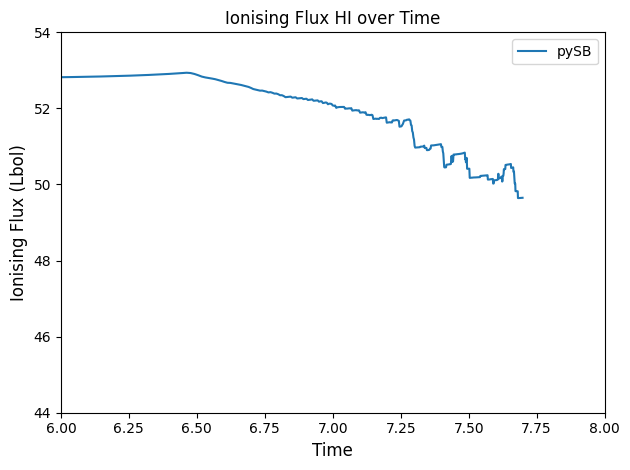

<ipython-input-255-4fdb73e0e933>:20: RuntimeWarning: divide by zero encountered in log10
  times_steps_log = np.log10(times_steps)
<ipython-input-255-4fdb73e0e933>:22: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(times_steps), population_ion_HEI_flux_iterations, label='pySB')


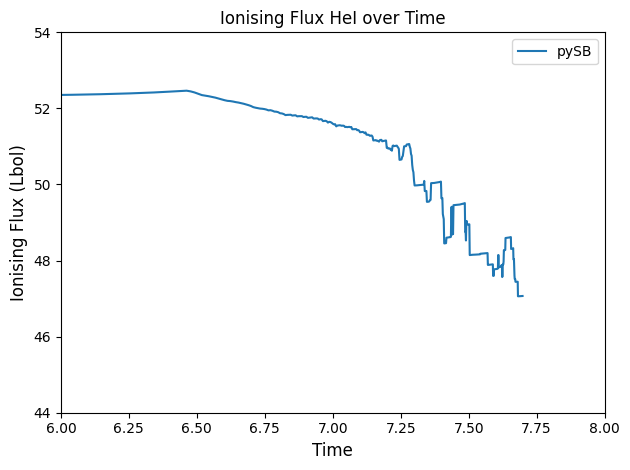

<ipython-input-255-4fdb73e0e933>:35: RuntimeWarning: divide by zero encountered in log10
  times_steps_log = np.log10(times_steps)
<ipython-input-255-4fdb73e0e933>:37: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(times_steps), population_ion_HEII_flux_iterations, label='pySB')


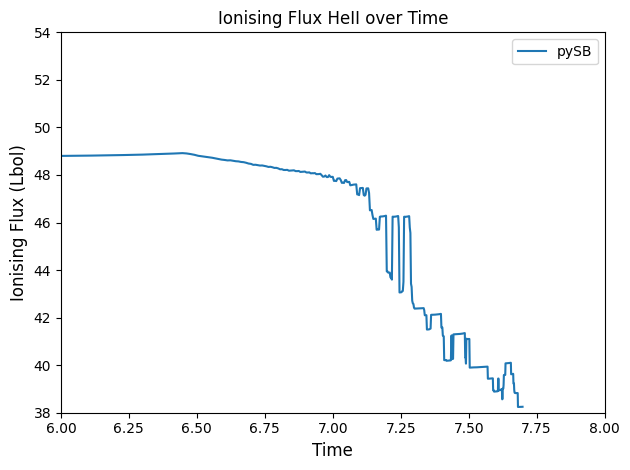

<ipython-input-255-4fdb73e0e933>:51: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(times_steps), population_ion_L_flux_iterations, label='pySB')


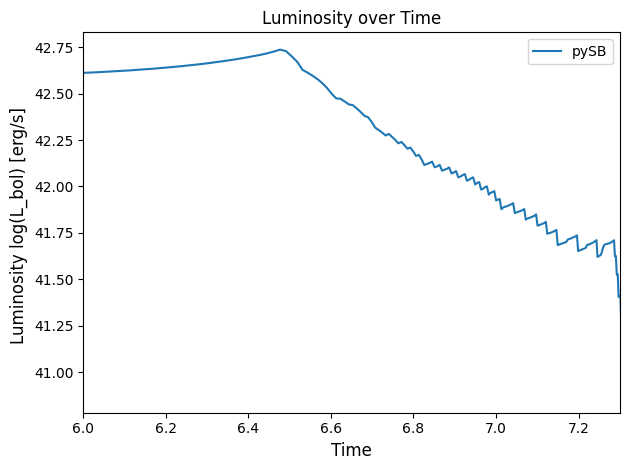

In [255]:
if plot_ion_flux == True:

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    #ax.plot(np.log10(times_steps_SB99), HI_ionflux_SB99, label='SB99')#-1.9)
    ax.plot(np.log10(times_steps), population_ion_HI_flux_iterations, label='pySB')
    plt.xlim(6.,8.)
    plt.ylim(44.,54.)
    plt.title('Ionising Flux HI over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Ionising Flux (Lbol)', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    times_steps_log = np.log10(times_steps)
    #ax.plot(np.log10(times_steps_SB99), HEI_ionflux_SB99, label='SB99')
    ax.plot(np.log10(times_steps), population_ion_HEI_flux_iterations, label='pySB')
    plt.xlim(6.,8.)
    plt.ylim(44.,54.)
    plt.title('Ionising Flux HeI over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Ionising Flux (Lbol)', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    times_steps_log = np.log10(times_steps)
    #ax.plot(np.log10(times_steps_SB99), HEII_ionflux_SB99, label='SB99')
    ax.plot(np.log10(times_steps), population_ion_HEII_flux_iterations, label='pySB')
    plt.xlim(6.,8.)
    plt.ylim(38.,54.)
    plt.title('Ionising Flux HeII over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Ionising Flux (Lbol)', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    #ax.plot(np.log10(times_steps_SB99), Lbol_SB99, label='SB99')
    ax.plot(np.log10(times_steps), population_ion_L_flux_iterations, label='pySB')
    plt.xlim(6.,7.3)
    plt.title('Luminosity over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Luminosity log(L_bol) [erg/s] ', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    if save_output == True:
        if IMF_mass_limits[-1] > 120.:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotVMSbololum.txt', population_ion_L_flux_iterations)
                np.savetxt(SBmodel_name + '/rotVMSion_flux_HI.txt', population_ion_HI_flux_iterations)
                np.savetxt(SBmodel_name + '/rotVMSion_flux_HeI.txt', population_ion_HEI_flux_iterations)
                np.savetxt(SBmodel_name + '/rotVMSion_flux_HeII.txt', population_ion_HEII_flux_iterations)
            else:
                np.savetxt(SBmodel_name + '/VMSbololum.txt', population_ion_L_flux_iterations)
                np.savetxt(SBmodel_name + '/VMSion_flux_HI.txt', population_ion_HI_flux_iterations)
                np.savetxt(SBmodel_name + '/VMSion_flux_HeI.txt', population_ion_HEI_flux_iterations)
                np.savetxt(SBmodel_name + '/VMSion_flux_HeII.txt', population_ion_HEII_flux_iterations)
        else:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotbololum.txt', population_ion_L_flux_iterations)
                np.savetxt(SBmodel_name + '/rotion_flux_HI.txt', population_ion_HI_flux_iterations)
                np.savetxt(SBmodel_name + '/rotion_flux_HeI.txt', population_ion_HEI_flux_iterations)
                np.savetxt(SBmodel_name + '/rotion_flux_HeII.txt', population_ion_HEII_flux_iterations)
            else:
                np.savetxt(SBmodel_name + '/bololum.txt', population_ion_L_flux_iterations)
                np.savetxt(SBmodel_name + '/ion_flux_HI.txt', population_ion_HI_flux_iterations)
                np.savetxt(SBmodel_name + '/ion_flux_HeI.txt', population_ion_HEI_flux_iterations)
                np.savetxt(SBmodel_name + '/ion_flux_HeII.txt', population_ion_HEII_flux_iterations)

if plot_wind == True:

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    ax.plot(times_steps_log, population_windpowers, label='pySB')
    plt.xlim(6.,7.25)
    plt.ylim(34.,42.)
    plt.title('Wind Power over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Wind Power [erg/sec]', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    ax.plot(times_steps_log, population_windmoms, label='pySB')
    #ax.plot(times_steps_log, population_windmoms_vink, label='vink')
    #ax.plot(times_steps_log, population_windmoms_leuven, label='leuven')
    #ax.plot(times_steps_log, population_windmoms_xshootu, label='xshootu')
    plt.xlim(6.,7.25)
    plt.ylim(27.5,33.)
    plt.title('Wind Momentum over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Wind Mom [erg/sec]', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    if save_output == True:
        if IMF_mass_limits[-1] > 120.:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotVMSwindpower.txt', population_windpowers)
                np.savetxt(SBmodel_name + '/rotVMSwindmom.txt', population_windmoms)
            else:
                np.savetxt(SBmodel_name + '/VMSwindpower.txt', population_windpowers)
                np.savetxt(SBmodel_name + '/VMSwindmom.txt', population_windmoms)
        else:
            if rot ==True:
                np.savetxt(SBmodel_name + '/rotwindpower.txt', population_windpowers)
                np.savetxt(SBmodel_name + '/rotwindmom.txt', population_windmoms)
            else:
                np.savetxt(SBmodel_name + '/windpower.txt', population_windpowers)
                np.savetxt(SBmodel_name + '/windmom.txt', population_windmoms)

if plot_uv_slope == True:

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    ax.plot(times_steps_log, population_uv_slopes_beta, label='pySB')
    plt.xlim(6.,9.)
    plt.title('Beta slope over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Beta UV slope', fontsize=12)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.legend()
    plt.show()

    if save_output == True:
        if IMF_mass_limits[-1] > 120.:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotVMSuv_slope.txt', population_uv_slopes_beta)
            else:
                np.savetxt(SBmodel_name + '/VMSuv_slope.txt', population_uv_slopes_beta)
        else:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotuv_slope.txt', population_uv_slopes_beta)
            else:
                np.savetxt(SBmodel_name + '/uv_slope.txt', population_uv_slopes_beta)

if plot_ew == True:

    fig=plt.figure()
    plt.style.use('default')
    ax=fig.add_subplot(111)
    ax.plot(times_steps_log, population_Ha_ew, label='pySB Ha')
    #ax.plot(times_steps_log, population_Hb_ew, label='pySB Hb')
    #ax.plot(np.log10(times_steps_SB99), Pb_ew, label='SB99 Pb')
    #ax.plot(np.log10(times_steps_SB99), Bg_ew, label='SB99 Bg')
    #ax.plot(times_steps_log, population_Pb_ew, label='pySB Pb')
    #ax.plot(times_steps_log, population_Bg_ew, label='pySB Bg')
    plt.xlim(6.,8.)
    plt.title('Equivalent widths over Time', fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Equivalent Width - EW', fontsize=12)
    plt.tight_layout()
    plt.legend()
    plt.show()

    if save_output == True:
        if IMF_mass_limits[-1] > 120.:
            if rot == True:
                np.savetxt(SBmodel_name + '/rotVMS_Haew.txt', population_Ha_ew)
                np.savetxt(SBmodel_name + '/rotVMS_Hbew.txt', population_Hb_ew)
                np.savetxt(SBmodel_name + '/rotVMS_Pbew.txt', population_Pb_ew)
                np.savetxt(SBmodel_name + '/rotVMS_Bgew.txt', population_Bg_ew)
            else:
                np.savetxt(SBmodel_name + '/VMS_Haew.txt', population_Ha_ew)
                np.savetxt(SBmodel_name + '/VMS_Hbew.txt', population_Hb_ew)
                np.savetxt(SBmodel_name + '/VMS_Pbew.txt', population_Pb_ew)
                np.savetxt(SBmodel_name + '/VMS_Bgew.txt', population_Bg_ew)
        else:
            if rot == True:
                np.savetxt(SBmodel_name + '/Haew.txt', population_Ha_ew)
                np.savetxt(SBmodel_name + '/Hbew.txt', population_Hb_ew)
                np.savetxt(SBmodel_name + '/Pbew.txt', population_Pb_ew)
                np.savetxt(SBmodel_name + '/Bgew.txt', population_Bg_ew)
            else:
                np.savetxt(SBmodel_name + '/Haew.txt', population_Ha_ew)
                np.savetxt(SBmodel_name + '/Hbew.txt', population_Hb_ew)
                np.savetxt(SBmodel_name + '/Pbew.txt', population_Pb_ew)
                np.savetxt(SBmodel_name + '/Bgew.txt', population_Bg_ew)